In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from time import time

from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, ExtraTreesClassifier, GradientBoostingClassifier, VotingClassifier, RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import VarianceThreshold, RFE, SelectKBest, chi2, RFECV
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor

import xgboost as xgb


pd.set_option('display.max_columns', None)  # Set to None to display all columns

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/kobe-bryant-shot-selection/sample_submission.csv.zip
/kaggle/input/kobe-bryant-shot-selection/data.csv.zip


----------------------
# EDA #
----------------------

In [2]:
# Import Data: 
kobe = pd.read_csv('/kaggle/input/kobe-bryant-shot-selection/data.csv.zip')
shot_id_rows = pd.DataFrame({'shot_id' : kobe[kobe['shot_made_flag'].isnull()].reset_index()['shot_id']})

display(kobe.head())
kobe.shape

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5


(30697, 25)

In [3]:
column_dict = {
    'game_event_id': 'The ID of the event within the game, represented as a nonconsecutive integer.',
    'game_id': 'The ID of the game, represented as an integer.',
    'lat': 'The latitude of the location where the shot was taken.',
    'loc_x': 'The x-coordinate on the basketball court where the shot was taken.',
    'loc_y': 'The y-coordinate on the basketball court where the shot was taken.',
    'lon': 'The longitude of the location where the shot was taken.',
    'minutes_remaining': 'The number of minutes remaining in the quarter when the shot was taken.',
    'period': 'The period of the game when the shot was taken (ranges from 1-7).',
    'playoffs': 'A binary variable indicating whether the game was a playoff game (1) or not (0).',
    'seconds_remaining': 'The number of seconds remaining in the minute when the shot was taken.',
    'shot_distance': 'The distance in feet from the basket when the shot was taken (ranges from 0-79).',
    'shot_made_flag': 'A binary variable indicating whether the shot was made (1) or missed (0), or null (NaN) if it is unknown.',
    'team_id': 'The ID of the team, which is always "1610612747" for the Los Angeles Lakers.',
    'shot_id': 'A unique ID number for the shot.',
    'action_type': 'The type of basketball shot attempted.',
    'combined_shot_type': 'The type of basketball shot attempted, collapsed into a smaller number of categories.',
    'shot_type': 'The type of shot attempted, either a 2-point field goal or 3-point field goal.',
    'shot_zone_area': 'The area on the court where the shot was taken.',
    'shot_zone_basic': 'The type of area on the court where the shot was taken.',
    'shot_zone_range': 'The range in feet from the basket where the shot was taken.',
    'team_name': 'The name of the team taking the shot, which is always "Los Angeles Lakers".',
    'matchup': 'The teams playing against each other and the location of the game (e.g., "LAL @ POR", "LAL vs. UTA").',
    'opponent': 'The name of the opposing team.',
    'season': 'The season in which the game was played, formatted as "YYYY-YY".',
    'game_date': 'The date on which the game was played, formatted as "YYYY-MM-DD".'
}


In [4]:
display(kobe.describe())
display(kobe.describe(include=['O']))

,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,seconds_remaining,shot_distance,shot_made_flag,team_id,shot_id
count,30697.000000,3.069700e+04,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,30697.000000,25697.000000,3.069700e+04,30697.000000
mean,249.190800,2.476407e+07,33.953192,7.110499,91.107535,-118.262690,4.885624,2.519432,0.146562,28.365085,13.437437,0.446161,1.610613e+09,15349.000000
std,150.003712,7.755175e+06,0.087791,110.124578,87.791361,0.110125,3.449897,1.153665,0.353674,17.478949,9.374189,0.497103,0.000000e+00,8861.604943
min,2.000000,2.000001e+07,33.253300,-250.000000,-44.000000,-118.519800,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.610613e+09,1.000000
25%,110.000000,2.050008e+07,33.884300,-68.000000,4.000000,-118.337800,2.000000,1.000000,0.000000,13.000000,5.000000,0.000000,1.610613e+09,7675.000000
50%,253.000000,2.090035e+07,33.970300,0.000000,74.000000,-118.269800,5.000000,3.000000,0.000000,28.000000,15.000000,0.000000,1.610613e+09,15349.000000
75%,368.000000,2.960047e+07,34.040300,95.000000,160.000000,-118.174800,8.000000,3.000000,0.000000,43.000000,21.000000,1.000000,1.610613e+09,23023.000000
max,659.000000,4.990009e+07,34.088300,248.000000,791.000000,-118.021800,11.000000,7.000000,1.000000,59.000000,79.000000,1.000000,1.610613e+09,30697.000000


,action_type,combined_shot_type,season,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_name,game_date,matchup,opponent
count,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697,30697
unique,57,6,20,2,6,7,5,1,1559,74,33
top,Jump Shot,Jump Shot,2005-06,2PT Field Goal,Center(C),Mid-Range,Less Than 8 ft.,Los Angeles Lakers,2016-04-13,LAL @ SAS,SAS
freq,18880,23485,2318,24271,13455,12625,9398,30697,50,1020,1978


In [5]:
kobe.isnull().sum() # Cool, no imputation needed! 

train =  kobe[pd.notnull(kobe['shot_made_flag'])]

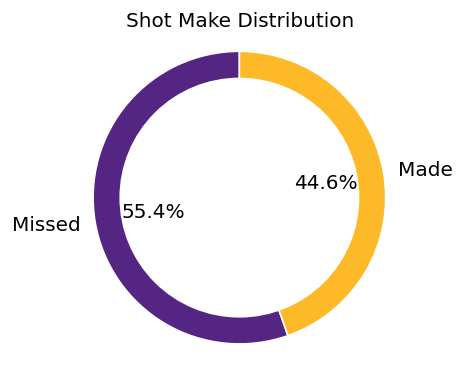

Made Shots: 11465 (44.6%)
Missed Shots: 14232 (55.4%)
Total: 25697


In [6]:
train =  kobe[pd.notnull(kobe['shot_made_flag'])]

class_counts = train['shot_made_flag'].value_counts()

# Set up the donut chart
fig, ax = plt.subplots(figsize=(3.5, 3.5), dpi=120)
labels = ['Missed', 'Made']
center_circle_radius = 0.82

# Create the donut chart
wedges, texts, autotexts = ax.pie(class_counts, labels=labels, autopct='%1.1f%%', startangle=90,
                                 colors=['#552583', '#FDB927'], wedgeprops={'edgecolor': 'white'})

# Customize the text labels
for text in texts:
    text.set_fontsize(12)
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(12)

# Add a circle at the center to create the donut hole
center_circle = plt.Circle((0, 0), center_circle_radius, fc='white')
fig.gca().add_artist(center_circle)

# Set a title for the donut chart
ax.set_title('Shot Make Distribution', fontsize=12)

# Equal aspect ratio ensures that the donut is drawn as a circle
ax.axis('equal')

# Display the donut chart
plt.show()


# Now with Numbers:
made_shots = train[train['shot_made_flag'] == 1]
missed_shots = train[train['shot_made_flag'] == 0]

print ("Made Shots: %i (%.1f%%)"%(len(made_shots), float(len(made_shots))/len(train)*100.0))
print ("Missed Shots: %i (%.1f%%)"%(len(missed_shots), float(len(missed_shots))/len(train)*100.0))
print ("Total: %i"%len(train))

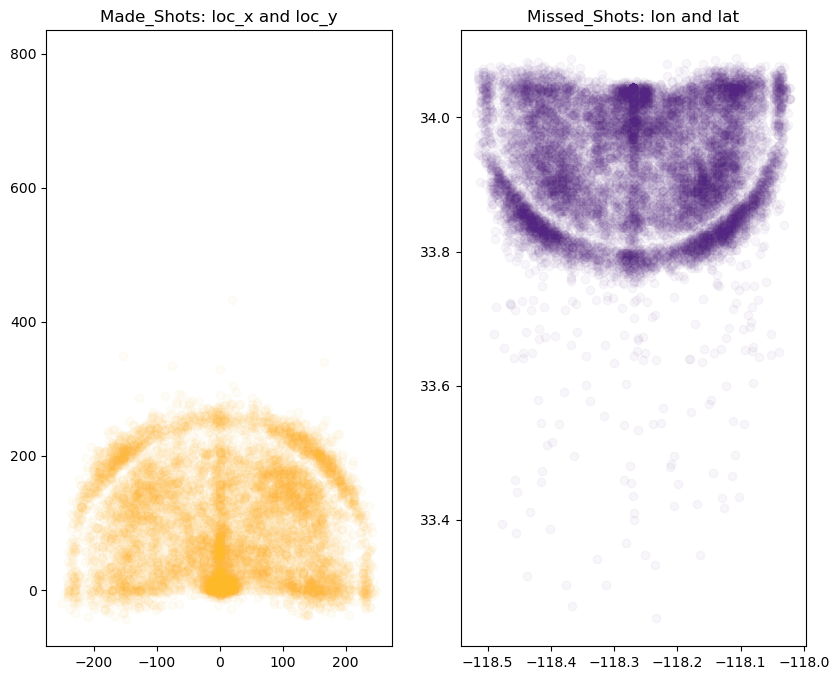

In [7]:
plt.figure(figsize=(9.8,8))

# loc_x and loc_y
plt.subplot(121)
plt.scatter(made_shots.loc_x, made_shots.loc_y, color='#FDB927', alpha=.04)
plt.ylim((-84, 835)) # To scale it properly
plt.title('Made_Shots: loc_x and loc_y')
plt.grid(visible=False)  # Remove gridlines

# lat and lon
plt.subplot(122)
plt.scatter(missed_shots.lon, missed_shots.lat, color='#552583', alpha=.04)
plt.title('Missed_Shots: lon and lat')
plt.grid(visible=False)  # Remove gridlines


So they really convey the same information. 

----------------------
# Prepare Our Data #
----------------------

### *Shots as a function of Time in Game* ###

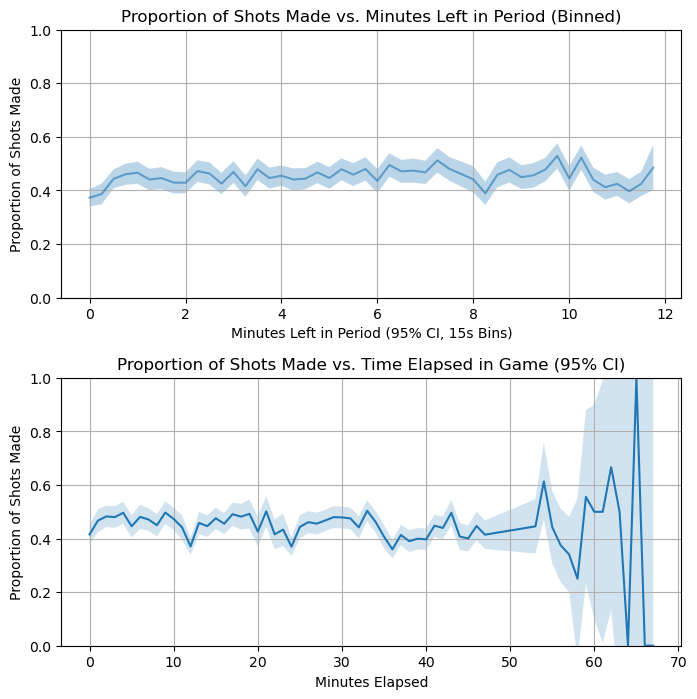

In [8]:
# Combine seconds and minutes for time_in_quarter:
kobe['time_in_period'] = kobe['seconds_remaining'] / 60 + kobe['minutes_remaining']

# Combine time_in_quarter and period for time_in_game:
kobe['time_elapsed'] = 999 # initialize the new variable 
kobe.loc[kobe['period'] <= 4, 'time_elapsed'] = kobe['time_in_period'] + (kobe['period'] - 1) * 12
kobe.loc[kobe['period'] > 4, 'time_elapsed'] = kobe['time_in_period'] + (kobe['period'] - 4) * 5 + 48

# Bin the data
bin_size = .25  # Size of each bin in minutes (i.e., 15 seconds)
bins = np.arange(0, kobe['time_in_period'].max() + bin_size, bin_size)
kobe['time_bin'] = pd.cut(kobe['time_in_period'], bins=bins, )

# Calculate proportions and confidence intervals for each bin
grouped_data = kobe.groupby('time_bin')['shot_made_flag']
proportions_binned = grouped_data.mean()
confidence_intervals = grouped_data.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96)  # 95% confidence interval

# Create line plot for the first subplot
fig, axs = plt.subplots(2, 1, figsize=(8, 8))

# Subplot 1: Proportion of Shots Made vs. Minutes Left in Period (Binned)
axs[0].plot(proportions_binned.index.categories.left, proportions_binned.values, linestyle='-', label='Proportion of Shots Made', alpha=0.6)
axs[0].fill_between(proportions_binned.index.categories.left, proportions_binned.values - confidence_intervals, proportions_binned.values + confidence_intervals, alpha=0.3, label='95% CI')  # Plot the confidence interval
axs[0].set_xlabel('Minutes Left in Period (95% CI, 15s Bins)')
axs[0].set_ylabel('Proportion of Shots Made')
axs[0].set_title('Proportion of Shots Made vs. Minutes Left in Period (Binned)')
axs[0].set_ylim(0, 1)  # Set the y-axis range
axs[0].grid(True)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.5)

# Calculate proportions and confidence intervals for the second subplot
kobe['time_elapsed'] = kobe['time_elapsed'].astype(int)
grouped_data = kobe.groupby('time_elapsed')['shot_made_flag']
proportions2 = grouped_data.mean()
confidence_intervals = grouped_data.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96) # 95% confidence interval

# Some minutes he took 0 shots (causing a non-existent CI), so fill those in with a [0,1] CI:
confidence_intervals = np.where(confidence_intervals == 0, 1, confidence_intervals) 

# Subplot 2: Proportion of Shots Made vs. Time Elapsed with confidence intervals
axs[1].plot(proportions2.index, proportions2.values)
axs[1].fill_between(proportions2.index, proportions2.values - confidence_intervals, proportions2.values + confidence_intervals, alpha=0.2)
axs[1].set_xlabel('Minutes Elapsed')
axs[1].set_ylabel('Proportion of Shots Made')
axs[1].set_title('Proportion of Shots Made vs. Time Elapsed in Game (95% CI)')
axs[1].set_ylim(0, 1)  # Set the y-axis range
axs[1].grid(True)

# Adjust the spacing between subplots
plt.subplots_adjust(hspace=0.3)

# Display the plot
plt.show()

Takeaways from these plots:
* It doesn't seem like the time left in period really matters beyond 0-2 minutes (and even then?)
* The man is extremely consistent during regulation (i.e., the first 48 minutes)-- It drops off after that, but the SE becomes too large for those shots to really matter much. It's possible both of these variables can be dropped. 

Let's see if simply looking at period is more helpful


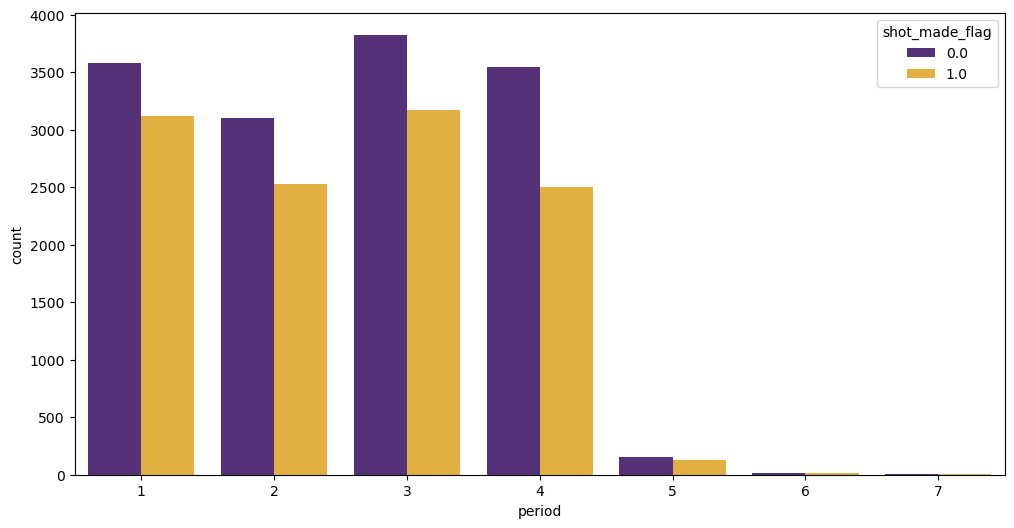

        shot_made_flag_mean  count
period                            
1                  0.465672   6700
2                  0.448802   5635
3                  0.453442   7002
4                  0.413702   6043
5                  0.442857    280
6                  0.466667     30
7                  0.428571      7


In [9]:
# Period
plt.figure(figsize=(12,6))
sns.countplot(x="period", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"})
plt.show()

freq_table = pd.pivot_table(kobe, values='shot_made_flag', index='period', aggfunc=['mean', 'count'])
freq_table.columns = ['shot_made_flag_mean', 'count']
print(freq_table)

Nope, period doesn't seem particularly useful. 

Let's explore the end of games to see if clutch time is any different from the rest. 

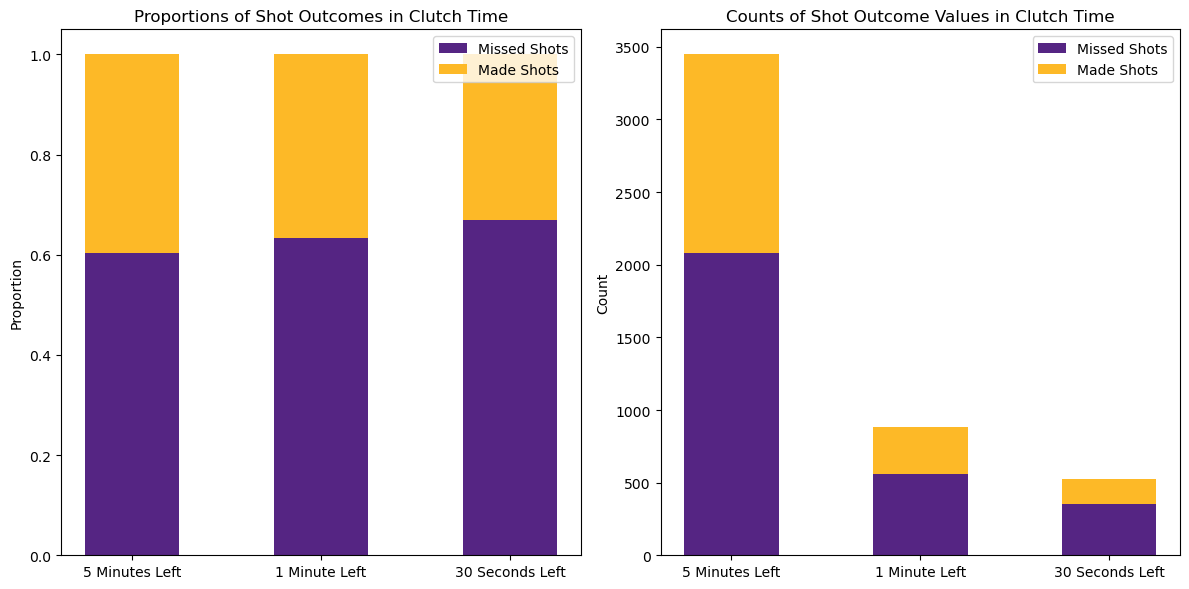

In [10]:
# There are different ways to think about clutch time, so let's look at them all:

# Filter the DataFrame based on the specified conditions
clutch_time_5m = kobe[(kobe['period'] >= 4) & (kobe['time_in_period'] <= 5)]
clutch_time_1m = kobe[(kobe['period'] >= 4) & (kobe['time_in_period'] <= 1)]
clutch_time_30s = kobe[(kobe['period'] >= 4) & (kobe['time_in_period'] <= 0.5)]

# Calculate the proportions
proportions_5m = clutch_time_5m['shot_made_flag'].value_counts(normalize=True)
proportions_1m = clutch_time_1m['shot_made_flag'].value_counts(normalize=True)
proportions_30s = clutch_time_30s['shot_made_flag'].value_counts(normalize=True)

# Data
categories = ['5 Minutes Left', '1 Minute Left', '30 Seconds Left']
bar1 = [proportions_5m[0], proportions_1m[0], proportions_30s[0]]
bar2 = [proportions_5m[1], proportions_1m[1], proportions_30s[1]]

# Positions of the bars on the x-axis
x = np.arange(len(categories))

# Create the figure and axes
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot the bars for the shot outcomes
ax1.bar(x, bar1, width=0.5, color='#552583', label='Missed Shots')
ax1.bar(x, bar2, bottom=bar1, width=0.5, color='#FDB927', label='Made Shots')

# Customize the plot for shot outcomes
ax1.set_xticks(x)
ax1.set_xticklabels(categories)
ax1.set_ylabel('Proportion')
ax1.set_title('Proportions of Shot Outcomes in Clutch Time')
ax1.legend()

# Plot the bars for the shot_made_flag values
ax2.bar(x, [clutch_time_5m['shot_made_flag'].value_counts()[0], 
            clutch_time_1m['shot_made_flag'].value_counts()[0], 
            clutch_time_30s['shot_made_flag'].value_counts()[0]], 
        width=0.5, color='#552583', label='Missed Shots')
ax2.bar(x, [clutch_time_5m['shot_made_flag'].value_counts()[1], 
            clutch_time_1m['shot_made_flag'].value_counts()[1], 
            clutch_time_30s['shot_made_flag'].value_counts()[1]], 
        bottom=[clutch_time_5m['shot_made_flag'].value_counts()[0], 
                clutch_time_1m['shot_made_flag'].value_counts()[0], 
                clutch_time_30s['shot_made_flag'].value_counts()[0]], 
        width=0.5, color='#FDB927', label='Made Shots')

# Customize the plot for shot_made_flag values
ax2.set_xticks(x)
ax2.set_xticklabels(categories)
ax2.set_ylabel('Count')
ax2.set_title('Counts of Shot Outcome Values in Clutch Time')
ax2.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the plot
plt.show()


So he does seem to make more of the shots as time runs out, but we're also working with a prety small sample size so it's probably not even worth including. 

### *Home vs. Away games* ###

<AxesSubplot:xlabel='home', ylabel='count'>

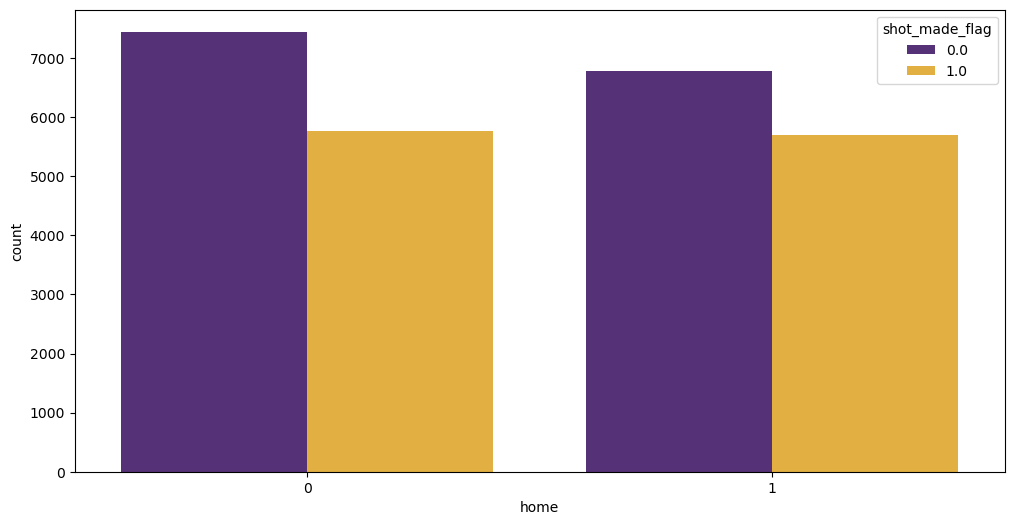

In [11]:
# Create a column that indexes whether a game is home or away
kobe['home'] = 999
kobe.loc[kobe['matchup'].str.contains('@'), 'home'] = 0
kobe.loc[kobe['matchup'].str.contains('vs.'), 'home'] = 1

# Same data as a histogram
plt.figure(figsize=(12,6))
sns.countplot(x="home", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"})

               shot_made_flag_mean  count
playoffs_home                            
0                         0.436349  11241
1                         0.457001  10698
2                         0.436834   1971
3                         0.453274   1787 




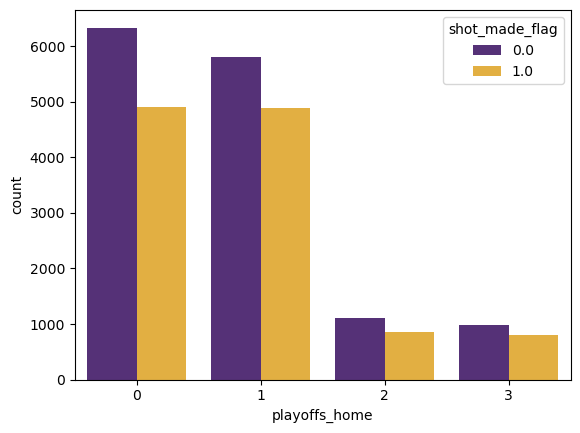

In [12]:
# Does home court matter more in the playoffs (and vice versa)?

kobe['playoffs_home'] = (kobe['playoffs']*2) + kobe['home']

# Create figure with two subplots
sns.countplot(x="playoffs_home", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"})

freq_table = pd.pivot_table(kobe, values='shot_made_flag', index='playoffs_home', aggfunc=['mean', 'count'])
freq_table.columns = ['shot_made_flag_mean', 'count']
freq_table = freq_table.sort_values(by='count', ascending=False)
print(freq_table, "\n\n")


That's a no!

### *Shots made as a function of career year* ###

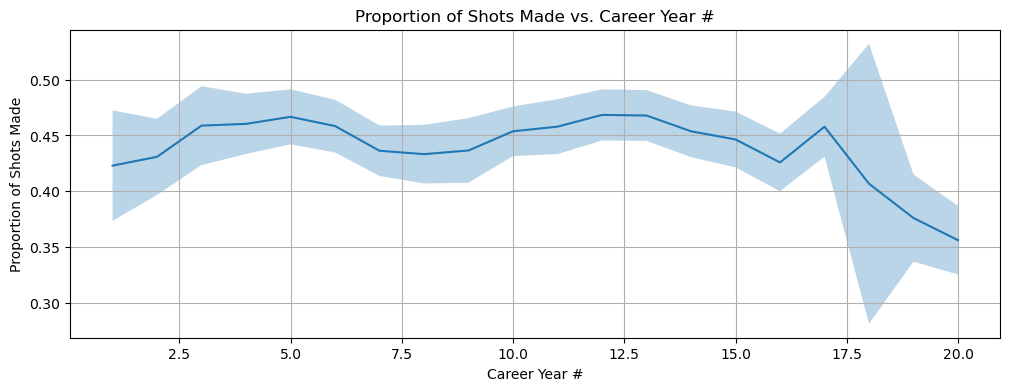

<AxesSubplot:xlabel='career_year', ylabel='count'>

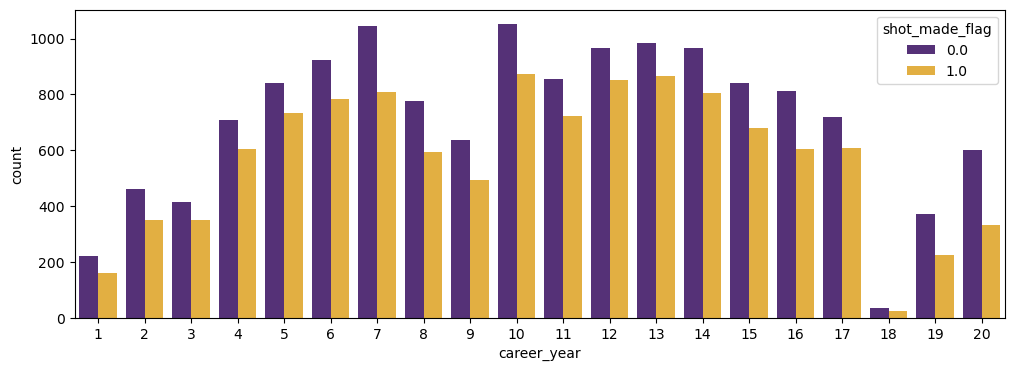

In [13]:
# Get year of career from the season variable
def recode_year_range(year_range):
    start_year = int(year_range[:4])
    return start_year - 1995

kobe['career_year'] = kobe['season'].apply(recode_year_range)

# Calculate proportions and confidence intervals
groups = kobe.groupby('career_year')['shot_made_flag']
proportions = groups.mean()
confidence_intervals = groups.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96)  # 95% confidence interval

# Create line plot with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(proportions.index, proportions.values)
plt.fill_between(proportions.index, proportions - confidence_intervals, proportions + confidence_intervals, alpha=0.3)
plt.xlabel('Career Year #')
plt.ylabel('Proportion of Shots Made')
plt.title('Proportion of Shots Made vs. Career Year #')
plt.grid(True)
plt.show()

# Same data as a histogram
plt.figure(figsize=(12,4))
sns.countplot(x="career_year", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"})

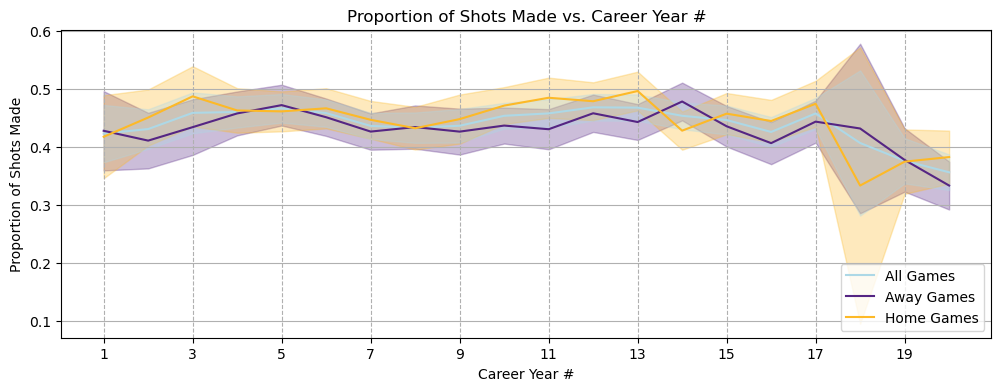

In [14]:
# Calculate proportions and confidence intervals
groups_all = kobe.groupby('career_year')['shot_made_flag']
proportions_all = groups_all.mean()
confidence_intervals_all = groups_all.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96)  # 95% confidence interval

groups_home = kobe[kobe['home'] == 1].groupby('career_year')['shot_made_flag']
proportions_home = groups_home.mean()
confidence_intervals_home = groups_home.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96)  # 95% confidence interval

groups_away = kobe[kobe['home'] == 0].groupby('career_year')['shot_made_flag']
proportions_away = groups_away.mean()
confidence_intervals_away = groups_away.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96)  # 95% confidence interval

# Create line plot with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(proportions_all.index, proportions_all.values, label='All Games', color='lightblue')
plt.plot(proportions_away.index, proportions_away.values, label='Away Games', color='#552583')
plt.plot(proportions_home.index, proportions_home.values, label='Home Games', color='#FDB927')

# Add confidence intervals
plt.fill_between(proportions_away.index, proportions_away - confidence_intervals_away, proportions_away + confidence_intervals_away, alpha=0.3, color='#552583')
plt.fill_between(proportions_home.index, proportions_home - confidence_intervals_home, proportions_home + confidence_intervals_home, alpha=0.3, color='#FDB927')
plt.fill_between(proportions_all.index, proportions_all - confidence_intervals_all, proportions_all + confidence_intervals_all, alpha=0.3, color='lightblue')

plt.xlabel('Career Year #')
plt.ylabel('Proportion of Shots Made')
plt.title('Proportion of Shots Made vs. Career Year #')
plt.grid(True)

# Move the legend to the bottom left
plt.legend(loc='lower right')

# Set xticks for grid lines
xticks = proportions_all.index[::2]  # Specify every other value of career_year
plt.xticks(xticks)

plt.grid(True, axis='x', linestyle='--')  # Add grid lines for x-axis
plt.show()

Home court miiiight matter more some years than others? But given the narrow range on the y-axis I'd say it's not worth including

### *Shots made as a function of time in season* ###

In [15]:
# Create a variable that generally tracks how far into the season 

# convert 'date' column to datetime objects
kobe['game_date'] = pd.to_datetime(kobe['game_date'])

# extract month from each date and assign to new column
kobe['month'] = kobe['game_date'].dt.month
kobe['year'] = kobe['game_date'].dt.year

# calculate number of months since previous November for each date
# Note: Season starts at the end of Oct so Oct games are counted as Nov.
kobe['months_into_season'] = ((kobe['month'] - 11) % 12 + 12) % 12
kobe.loc[kobe['month'] == 10, 'months_into_season'] = 0 

# Account for seasons with lockouts/ delayed starts:
kobe.loc[kobe['season'] == '1998-99', 'months_into_season'] = kobe['month'] - 2
kobe.loc[kobe['season'] == '2011-12', 'months_into_season'] = kobe['month']-1
kobe.loc[(kobe['season'] == '2011-12') & (kobe['month'] == 12), 'months_into_season'] = 0


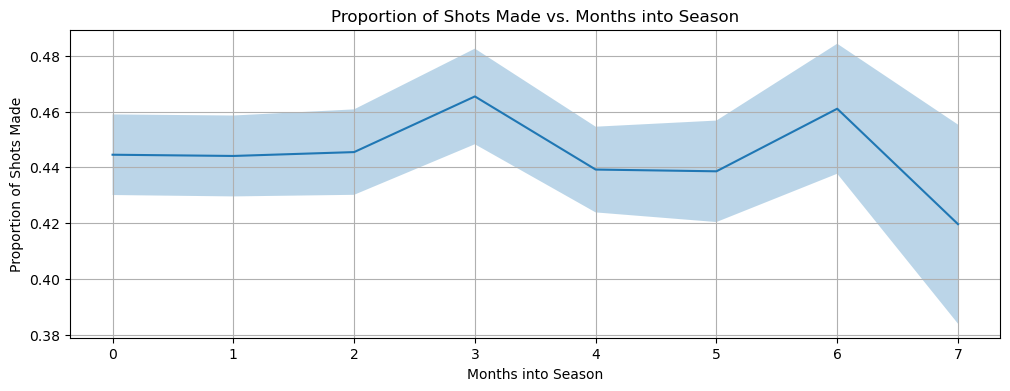

In [16]:
# Calculate proportions and confidence intervals
groups = kobe.groupby('months_into_season')['shot_made_flag']
proportions = groups.mean()
confidence_intervals = groups.aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96)  # 95% confidence interval

# Create line plot with confidence intervals
plt.figure(figsize=(12, 4))
plt.plot(proportions.index, proportions.values)
plt.fill_between(proportions.index, proportions - confidence_intervals, proportions + confidence_intervals, alpha=0.3)
plt.xlabel('Months into Season')
plt.ylabel('Proportion of Shots Made')
plt.title('Proportion of Shots Made vs. Months into Season')
plt.grid(True)
plt.show()

Doesn't seem to be a consistent enough pattern to justify keeping it (note the tiny intervals on the y-axis in the line plot)

### *Shots made as a function of shot type* ###

In [17]:
# Let's look at all of the action_type values: 
# Note: 'Tip' isn't included because it's covered by combined_shot_type
def map_shot_type(shot_type):
    if 'Running Reverse' in shot_type:
        return 'Running Reverse'
    elif 'Driving Finger Roll' in shot_type:
        return 'Driving Finger Roll'    
    elif 'Turnaround Fadeaway' in shot_type:
        return 'Turnaround Fadeaway'
    elif 'Driving Reverse' in shot_type:
        return 'Driving Reverse'
    elif 'Driving' in shot_type:
        return 'Driving'
    elif 'Running' in shot_type:
        return 'Running'
    elif 'Reverse' in shot_type:
        return 'Reverse'
    elif 'Alley Oop' in shot_type:
        return 'Alley Oop'
    elif 'Fadeaway' in shot_type:
        return 'Fadeaway'
    elif 'Follow Up' in shot_type:
        return 'Follow-Up'
    elif 'Turnaround' in shot_type:
        return 'Turnaround'
    elif 'Pullup' in shot_type:
        return 'Pullup'
    elif 'Step Back' in shot_type:
        return 'Step Back'
    elif 'Putback' in shot_type:
        return 'Putback'
    elif 'Cutting' in shot_type:
        return 'Cutting'
    elif 'Floating' in shot_type:
        return 'Floating'
    elif 'Finger Roll' in shot_type:
        return 'Finger Roll'    
    else:
        return 'Other'

# apply the function to create a new column
kobe['action_type_reduced'] = kobe['action_type'].apply(map_shot_type)

freq_table = pd.pivot_table(kobe, values='shot_made_flag', index='action_type_reduced', aggfunc=['mean', 'count'])
freq_table.columns = ['shot_made_flag_mean', 'count']
freq_table = freq_table.sort_values(by='count', ascending=False)
print(freq_table)

pd.crosstab(kobe['combined_shot_type'], kobe['action_type_reduced'], values=kobe['shot_made_flag'], aggfunc='mean', normalize='index')

                     shot_made_flag_mean  count
action_type_reduced                            
Other                           0.357862  19080
Driving                         0.772197   1971
Turnaround                      0.610010    959
Running                         0.752665    938
Fadeaway                        0.583982    899
Pullup                          0.719128    413
Reverse                         0.691932    409
Turnaround Fadeaway             0.584699    366
Alley Oop                       0.851852    162
Driving Finger Roll             0.866142    127
Step Back                       0.632075    106
Floating                        0.720430     93
Driving Reverse                 0.746988     83
Finger Roll                     0.648148     54
Putback                         0.642857     14
Follow-Up                       0.900000     10
Running Reverse                 0.571429      7
Cutting                         0.666667      6


action_type_reduced,Alley Oop,Cutting,Driving,Driving Finger Roll,Driving Reverse,Fadeaway,Finger Roll,Floating,Follow-Up,Other,Pullup,Putback,Reverse,Running,Running Reverse,Step Back,Turnaround,Turnaround Fadeaway
combined_shot_type,,,,,,,,,,,,,,,,,,
Bank Shot,0.000000,0.0000,0.173501,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.260252,0.141955,0.000000,0.000000,0.217885,0.000000,0.000000,0.206407,0.000000
Dunk,0.153919,0.0000,0.158679,0.000000,0.000000,0.00000,0.000000,0.00000,0.146223,0.146547,0.000000,0.097482,0.151781,0.145368,0.000000,0.000000,0.000000,0.000000
Hook Shot,0.000000,0.0000,0.260311,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,0.156454,0.000000,0.000000,0.000000,0.371732,0.000000,0.000000,0.211503,0.000000
Jump Shot,0.000000,0.0000,0.082765,0.000000,0.000000,0.10875,0.000000,0.13416,0.000000,0.062462,0.134802,0.000000,0.000000,0.139071,0.000000,0.117706,0.111399,0.108884
Layup,0.086185,0.0802,0.089190,0.104196,0.089862,0.00000,0.077972,0.00000,0.000000,0.046368,0.000000,0.080200,0.076587,0.080200,0.068742,0.000000,0.120299,0.000000
Tip Shot,0.000000,0.0000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


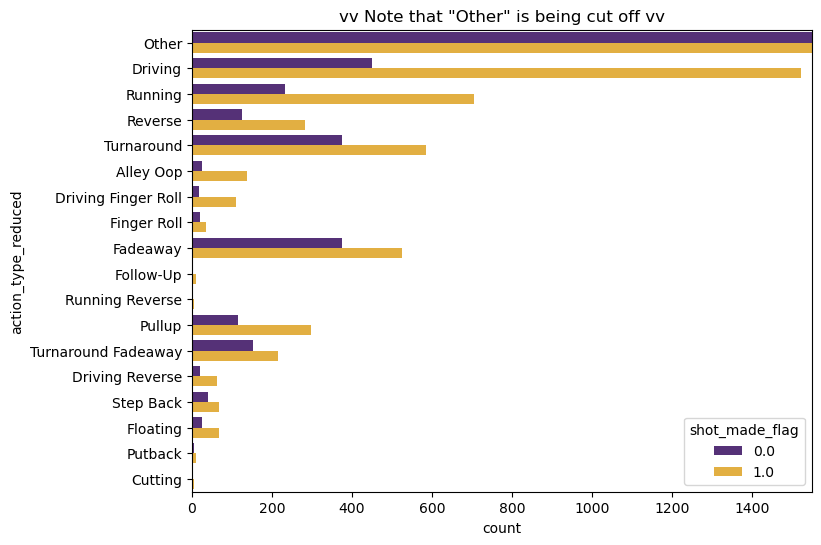

In [18]:
plt.figure(figsize=(8,6))
sns.countplot(y="action_type_reduced", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"})
plt.title('vv Note that "Other" is being cut off vv')
plt.xlim(0, 1550)
plt.show()

#### Takeaways from the table and the plot above: ####
* Looks likek driving/ running/ cutting can be combined. Which makes sense because they're all kind of the same thing anyway. 
* Not enough Putback, Running Reverse, Follow-Up to be their own thing
* Turnaround Fadeaway can be combined with Fadeaway
* Driving Reverse and Running Reverse can be combined with Driving and Reverse, respectively

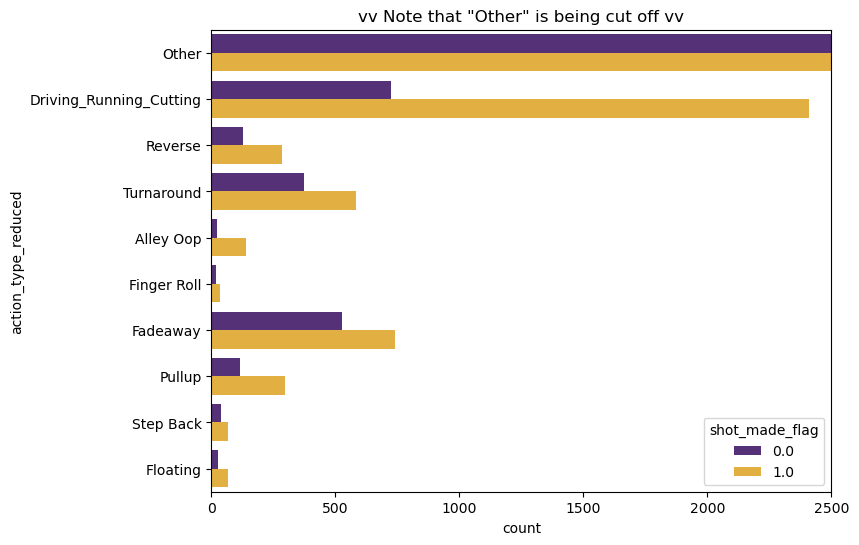

In [19]:
def map_shot_type_2(action_type_reduced):
    if 'Driving' in action_type_reduced:
        return 'Driving_Running_Cutting'
    elif 'Running' in action_type_reduced:
        return 'Driving_Running_Cutting'
    elif 'Cutting' in action_type_reduced:
        return 'Driving_Running_Cutting'
    elif 'Putback' in action_type_reduced:
        return 'Other'
    elif 'Follow-Up' in action_type_reduced:
        return 'Other'
    elif 'Turnaround Fadeaway' in action_type_reduced:
        return 'Fadeaway'
    else:
        return action_type_reduced

# Run the function:    
kobe['action_type_reduced'] = kobe['action_type_reduced'].apply(map_shot_type_2)

plt.figure(figsize=(8,6))
sns.countplot(y="action_type_reduced", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"})
plt.title('vv Note that "Other" is being cut off vv')
plt.xlim(0, 2500)
plt.show()

### *Shots made as a function of shot location* ###

Text(0.5, 1.0, 'shot_zone_range')

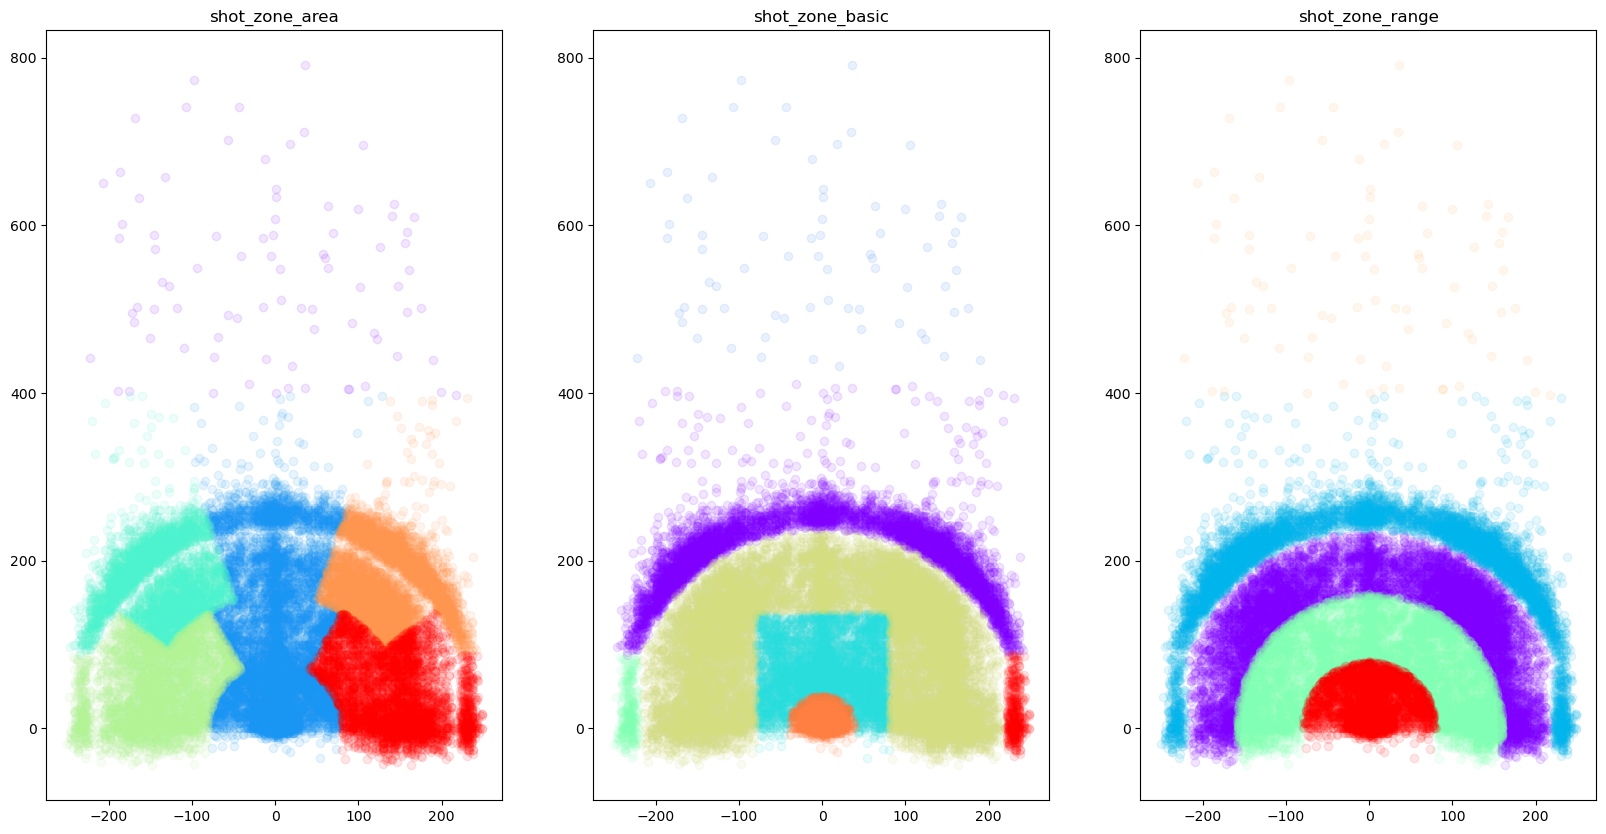

In [20]:
# Exploring the importance of shot zones
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = kobe.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_zone_basic')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_zone_range')
plt.title('shot_zone_range')

Note that all three have the same backcourt classification. 

Let's start looking at the binning of shot_distance.

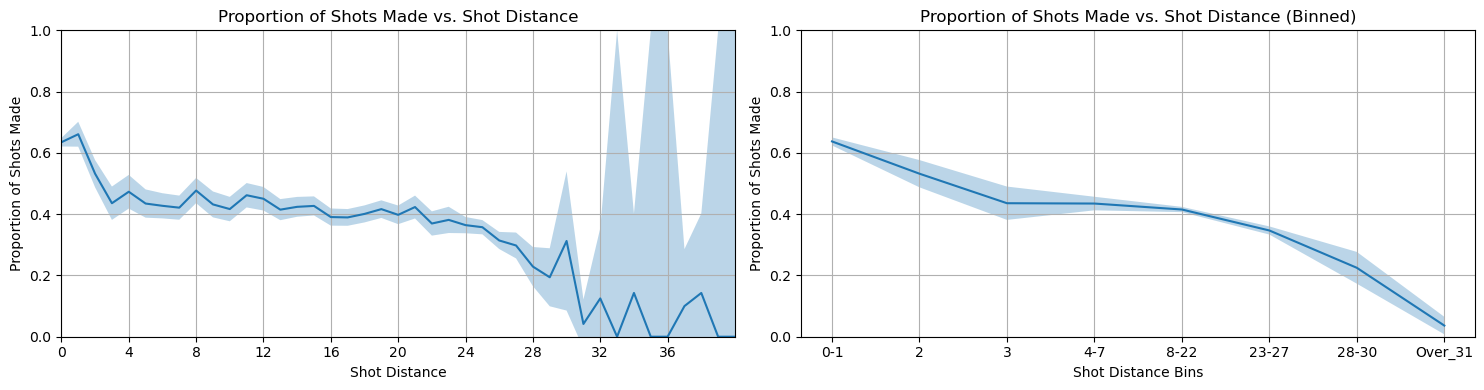

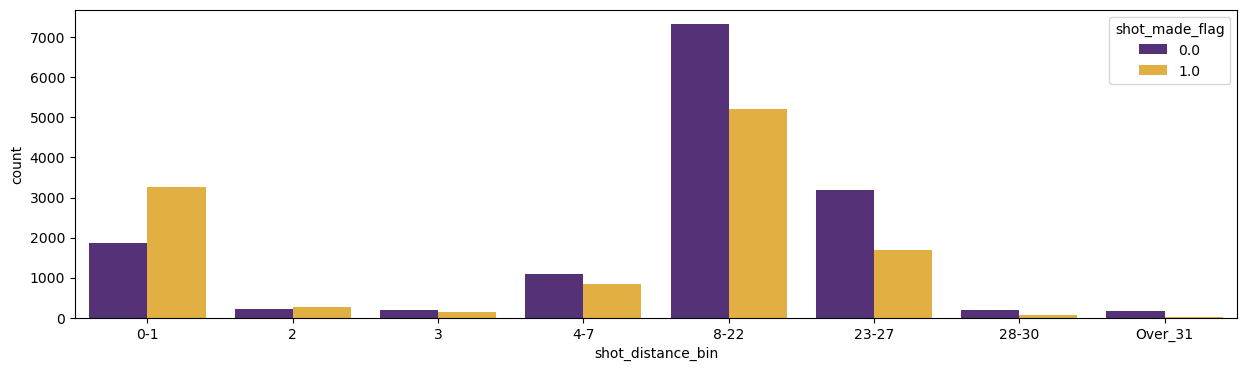

In [21]:
# Calculate proportions
proportions = kobe.groupby('shot_distance')['shot_made_flag'].mean()

# Create figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 4))

# Plot the first line plot on the left subplot
proportions = kobe.groupby('shot_distance')['shot_made_flag'].mean()
confidence_intervals = kobe.groupby('shot_distance')['shot_made_flag'].aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96)  # 95% confidence interval

# He took zero shots from some distances (causing a non-existent CI), so fill those in with a [0,1] CI:
confidence_intervals = np.where(confidence_intervals == 0, 1, confidence_intervals) 

axes[0].plot(proportions.index, proportions.values)
axes[0].fill_between(proportions.index, proportions - confidence_intervals, proportions + confidence_intervals, alpha=0.3)
axes[0].set_xlabel('Shot Distance')
axes[0].set_ylabel('Proportion of Shots Made')
axes[0].set_title('Proportion of Shots Made vs. Shot Distance')
axes[0].set_ylim(0, 1)  # Set the y-axis range
axes[0].set_xlim(0, 40)
axes[0].set_xticks(list(range(0, 40))[::4])
axes[0].grid(True)

# Plot the second line plot on the right subplot
# Seems to make a lot of sense as bins: 
bin_edges = [-1, 1, 2, 3, 7, 22, 27, 30, 80]
bin_labels = ['0-1', '2', '3', '4-7', '8-22', '23-27', '28-30', 'Over_31']

# Bin the shot_distance column based on that plot
kobe['shot_distance_bin'] = pd.cut(kobe['shot_distance'], bins=bin_edges, labels=bin_labels)
proportions = kobe.groupby('shot_distance_bin')['shot_made_flag'].mean()
confidence_intervals = kobe.groupby('shot_distance_bin')['shot_made_flag'].aggregate(lambda x: np.std(x) / np.sqrt(x.count()) * 1.96)  # 95% confidence interval

axes[1].plot(proportions.index, proportions.values)
axes[1].fill_between(proportions.index, proportions - confidence_intervals, proportions + confidence_intervals, alpha=0.3)
axes[1].set_xlabel('Shot Distance Bins')
axes[1].set_ylabel('Proportion of Shots Made')
axes[1].set_ylim(0, 1)  # Set the y-axis range
axes[1].set_title('Proportion of Shots Made vs. Shot Distance (Binned)')
axes[1].grid(True)

plt.tight_layout() # Set tight layout for better spacing between subplots
plt.show()

# Histogram:
plt.figure(figsize=(15,4))
sns.countplot(x="shot_distance_bin", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"})
plt.show()

In [22]:
# Looks like it's' useful, so I'll give the values a more informative name: 
kobe['shot_distance_bin'] = 'shot_distnace_' + kobe['shot_distance_bin'].astype(str)

Now let's look at the area on the court:

In [23]:
display(pd.crosstab(kobe['shot_zone_area'], kobe['shot_zone_basic'], values=kobe['shot_made_flag'], aggfunc='mean', normalize='index'))
pd.crosstab(kobe['shot_type'], kobe['shot_zone_basic'], values=kobe['shot_made_flag'], aggfunc='mean', normalize='index')

shot_zone_basic,Above the Break 3,Backcourt,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3
shot_zone_area,,,,,,,
Back Court(BC),0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.000000
Center(C),0.176939,0.0,0.251045,0.000000,0.231081,0.340934,0.000000
Left Side Center(LC),0.437246,0.0,0.000000,0.000000,0.562754,0.000000,0.000000
Left Side(L),0.000000,0.0,0.349480,0.314028,0.336492,0.000000,0.000000
Right Side Center(RC),0.451116,0.0,0.000000,0.000000,0.548884,0.000000,0.000000
Right Side(R),0.000000,0.0,0.394766,0.000000,0.326597,0.000000,0.278636


shot_zone_basic,Above the Break 3,Backcourt,In The Paint (Non-RA),Left Corner 3,Mid-Range,Restricted Area,Right Corner 3
shot_type,,,,,,,
2PT Field Goal,0.252691,0.000000,0.229637,0.000000,0.205291,0.312381,0.000000
3PT Field Goal,0.222911,0.011478,0.000000,0.251129,0.283988,0.000000,0.230494


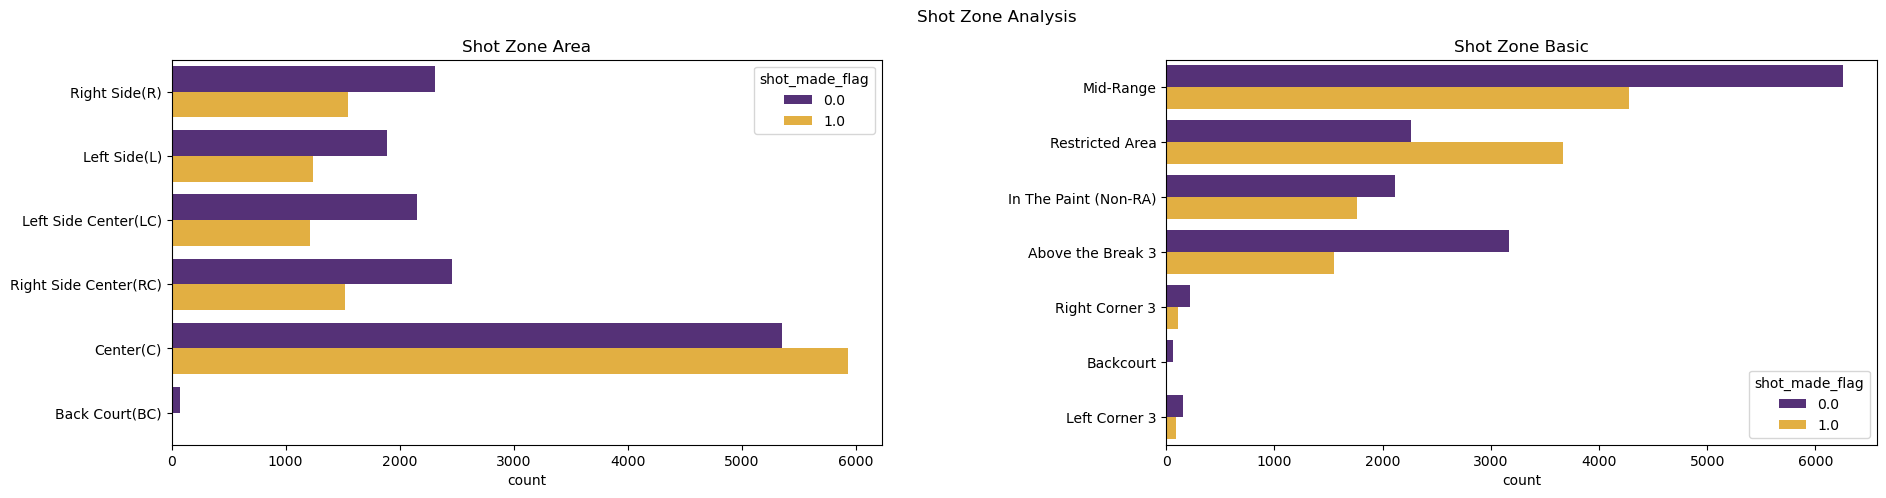

In [24]:
# Create a figure with three subplots
fig, axes = plt.subplots(1, 2, figsize=(22, 5))

# Plot first count plot on the first subplot
sns.countplot(y="shot_zone_area", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"}, ax=axes[0])
axes[0].set_title('Shot Zone Area')
axes[0].set_ylabel('')

# Plot second count plot on the second subplot
sns.countplot(y="shot_zone_basic", hue="shot_made_flag", data=kobe, palette={0: "#552583", 1: "#FDB927"}, ax=axes[1])
axes[1].set_title('Shot Zone Basic')
axes[1].set_ylabel('')

# Add a common title for the entire figure
plt.suptitle('Shot Zone Analysis')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.4)

# Display the plot
plt.show()

Doesn't look like he has much preference for left vs. right shots, but let's confirm. 

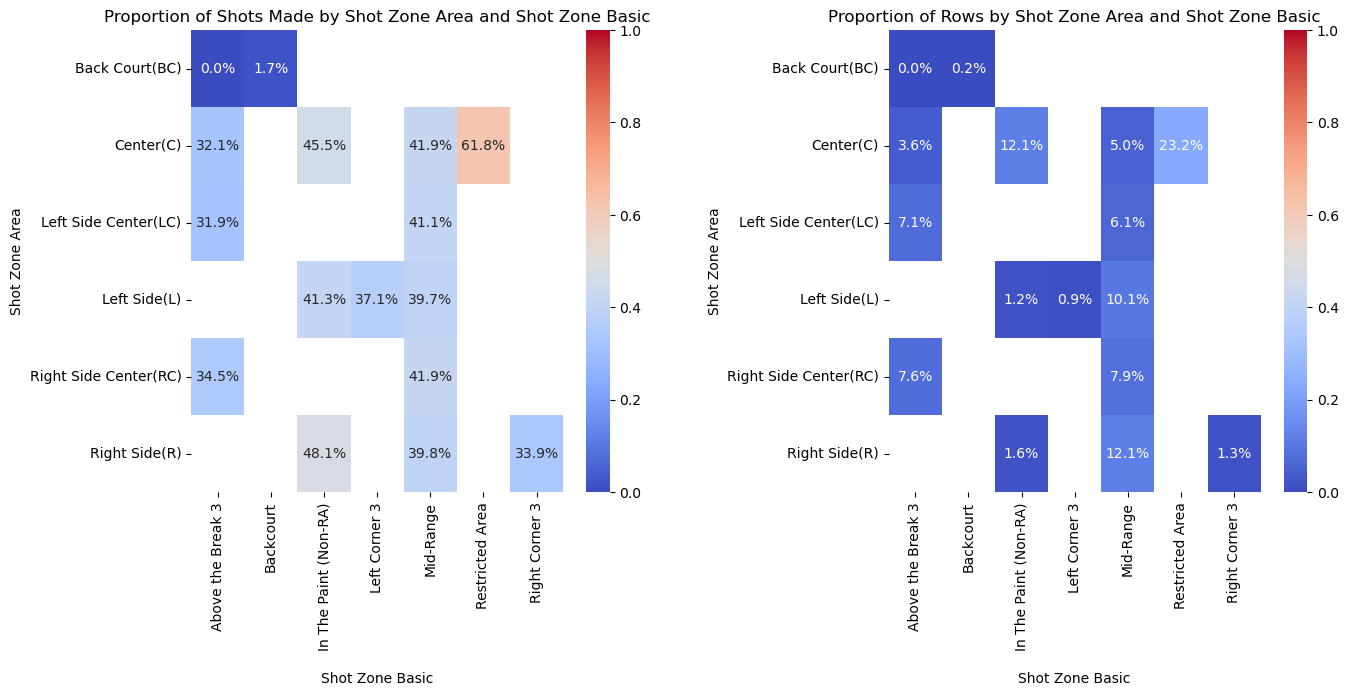

In [25]:
# Calculate the proportion of shots made for each combination of 'shot_zone_area' and 'shot_zone_basic'
proportions_shots_made = kobe.groupby(['shot_zone_area', 'shot_zone_basic'])['shot_made_flag'].mean().unstack()

# Calculate the proportion of rows for each combination of 'shot_zone_area' and 'shot_zone_basic'
counts = kobe.groupby(['shot_zone_area', 'shot_zone_basic']).size().unstack()
proportions_rows = counts / counts.sum().sum()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot proportion of shots made on the first subplot
sns.heatmap(proportions_shots_made, annot=True, cmap='coolwarm', cbar=True, fmt='.1%', vmin=0, vmax=1, ax=axes[0])
axes[0].set_xlabel('\nShot Zone Basic')
axes[0].set_ylabel('Shot Zone Area')
axes[0].set_title('Proportion of Shots Made by Shot Zone Area and Shot Zone Basic')

# Plot proportion of rows on the second subplot
sns.heatmap(proportions_rows, annot=True, cmap='coolwarm', cbar=True, fmt='.1%', vmin=0, vmax=1, ax=axes[1])
axes[1].set_xlabel('\nShot Zone Basic')
axes[1].set_ylabel('Shot Zone Area')
axes[1].set_title('Proportion of Rows by Shot Zone Area and Shot Zone Basic')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)

# Show the plot
plt.show()

#### Takeaways: ##
* L Center, R Center, and Center ATB 3's are all pretty similar and can prob be condensed
* As mentioned above, BC shots are redundant between these two columns
* L, R, and C ITP shots are all different and worth keeping
* LC 3 and RC 3 are redundant with the L and R labels
* His mid-range is suuuper consistent, regardless of where it is on the court
* All RA shots are in the center


In [26]:
kobe['shot_type_new'] = kobe["shot_zone_basic"] + " | " + kobe["shot_zone_area"]

kobe['shot_type_new'] = kobe['shot_type_new'].replace({
    'Above the Break 3 | Center(C)': 'ATB3',
    'Above the Break 3 | Left Side Center(LC)': 'ATB3',
    'Above the Break 3 | Right Side Center(RC)': 'ATB3',
    
    'Above the Break 3 | Back Court(BC)': 'BC',
    'Backcourt | Back Court(BC)': 'BC',
    
    'In The Paint (Non-RA) | Center(C)': 'C_ITP',
    'In The Paint (Non-RA) | Left Side(L)': 'L_ITP',
    'In The Paint (Non-RA) | Right Side(R)': 'R_ITP',   
    
    'Left Corner 3 | Left Side(L)': 'L_3',
    'Right Corner 3 | Right Side(R)': 'R_3',
    
    'Mid-Range | Center(C)': 'Mid',
    'Mid-Range | Left Side Center(LC)': 'Mid',
    'Mid-Range | Left Side(L)': 'Mid',
    'Mid-Range | Right Side Center(RC)': 'Mid',
    'Mid-Range | Right Side(R)': 'Mid',

    'Restricted Area | Center(C)': 'RA'
})

Now let's look at how this interacts with the shot distance bins I created earlier

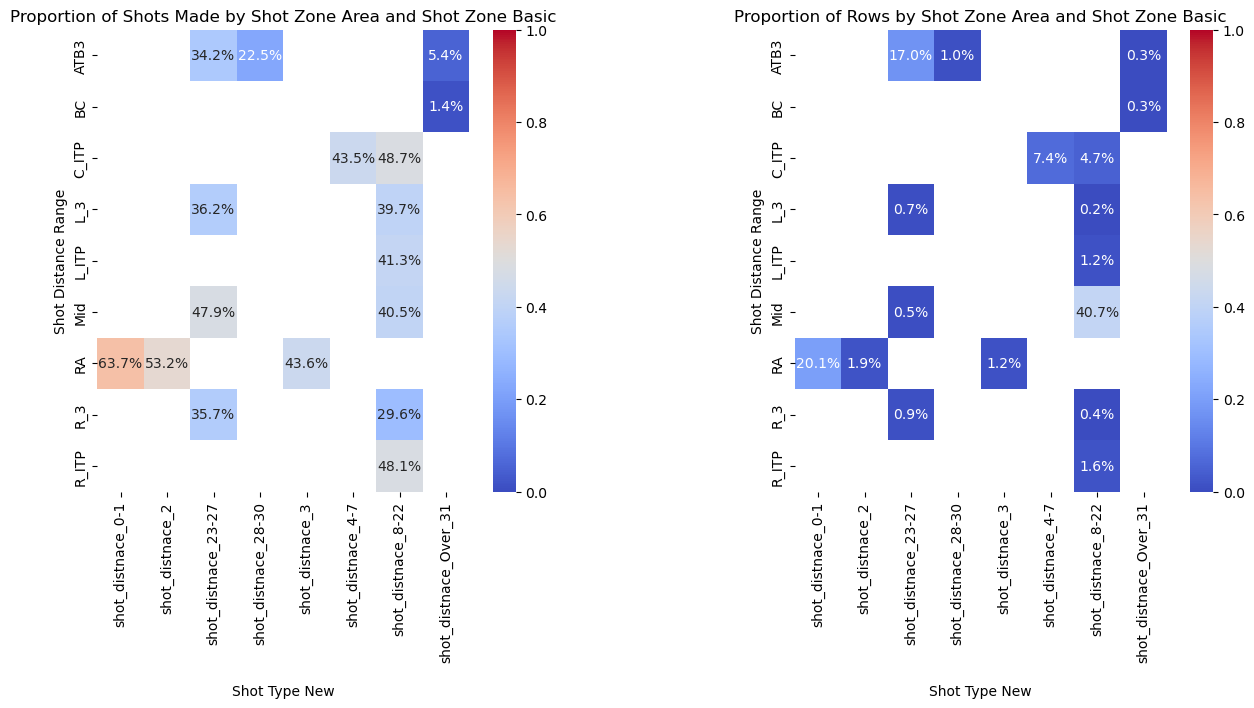

shot_type_new  shot_distance_bin    
ATB3           shot_distnace_23-27       5208
               shot_distnace_28-30        295
               shot_distnace_Over_31      105
BC             shot_distnace_Over_31       83
C_ITP          shot_distnace_4-7         2258
               shot_distnace_8-22        1448
L_3            shot_distnace_23-27        206
               shot_distnace_8-22          74
L_ITP          shot_distnace_8-22         382
Mid            shot_distnace_23-27        141
               shot_distnace_8-22       12484
RA             shot_distnace_0-1         6178
               shot_distnace_2            581
               shot_distnace_3            377
R_3            shot_distnace_23-27        274
               shot_distnace_8-22         113
R_ITP          shot_distnace_8-22         490
dtype: int64

In [27]:
# Calculate the proportion of shots made for each combination of 'shot_zone_area' and 'shot_zone_basic'
proportions_shots_made = kobe.groupby(['shot_type_new', 'shot_distance_bin'])['shot_made_flag'].mean().unstack()

# Calculate the proportion of rows for each combination of 'shot_zone_area' and 'shot_zone_basic'
counts = kobe.groupby(['shot_type_new', 'shot_distance_bin']).size().unstack()
proportions_rows = counts / counts.sum().sum()

# Create a figure with two subplots
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Plot proportion of shots made on the first subplot
sns.heatmap(proportions_shots_made, annot=True, cmap='coolwarm', cbar=True, fmt='.1%', vmin=0, vmax=1, ax=axes[0])
axes[0].set_xlabel('\nShot Type New')
axes[0].set_ylabel('Shot Distance Range')
axes[0].set_title('Proportion of Shots Made by Shot Zone Area and Shot Zone Basic')

# Plot proportion of rows on the second subplot
sns.heatmap(proportions_rows, annot=True, cmap='coolwarm', cbar=True, fmt='.1%', vmin=0, vmax=1, ax=axes[1])
axes[1].set_xlabel('\nShot Type New')
axes[1].set_ylabel('Shot Distance Range')
axes[1].set_title('Proportion of Rows by Shot Zone Area and Shot Zone Basic')

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.5)

# Show the plot
plt.show()

# Group by "shot_type_new" and "shot_distance_bin" and calculate the counts
grouped = kobe.groupby(["shot_type_new", "shot_distance_bin"]).size()
grouped[grouped > 0]

Based on this, I think it might be worth splitting ATB3, C_ITP, RA, and R3 columns by distance

In [28]:
# Concatenate "shot_type_new" and "shot_distance_bin" columns with a separator
kobe['shot_type_new2'] = kobe['shot_type_new']

kobe.loc[(kobe['shot_distance_bin'] == '23-27') & (kobe['shot_type_new'] == 'ATB3'), 'shot_type_new2'] = 'ATB_23_27ft'
kobe.loc[(kobe['shot_distance_bin'] == '28-30') & (kobe['shot_type_new'] == 'ATB3'), 'shot_type_new2'] = 'ATB_28_30ft'
kobe.loc[(kobe['shot_distance_bin'] == '31+'  ) & (kobe['shot_type_new'] == 'ATB3'), 'shot_type_new2'] = 'ATB_Over_31ft'

kobe.loc[(kobe['shot_distance_bin'] == '4-7'  ) & (kobe['shot_type_new'] == 'C_ITP'), 'shot_type_new2'] = 'C_ITP_4_7ft'
kobe.loc[(kobe['shot_distance_bin'] == '8-22' ) & (kobe['shot_type_new'] == 'C_ITP'), 'shot_type_new2'] = 'C_ITP_8_22ft'

kobe.loc[(kobe['shot_distance_bin'] == '0-1')  & (kobe['shot_type_new'] == 'RA'), 'shot_type_new2'] = 'RA_0_1ft'
kobe.loc[(kobe['shot_distance_bin'] == '2')    & (kobe['shot_type_new'] == 'RA'), 'shot_type_new2'] = 'RA_2ft'
kobe.loc[(kobe['shot_distance_bin'] == '3')    & (kobe['shot_type_new'] == 'RA'), 'shot_type_new2'] = 'RA_3ft'

kobe.loc[(kobe['shot_distance_bin'] == '8-22')  & (kobe['shot_type_new'] == 'R_3'), 'shot_type_new2'] = 'R3_8_22ft'
kobe.loc[(kobe['shot_distance_bin'] == '23-27') & (kobe['shot_type_new'] == 'R_3'), 'shot_type_new2'] = 'R3_23_27ft'


Text(0.5, 1.0, 'shot_zone_range')

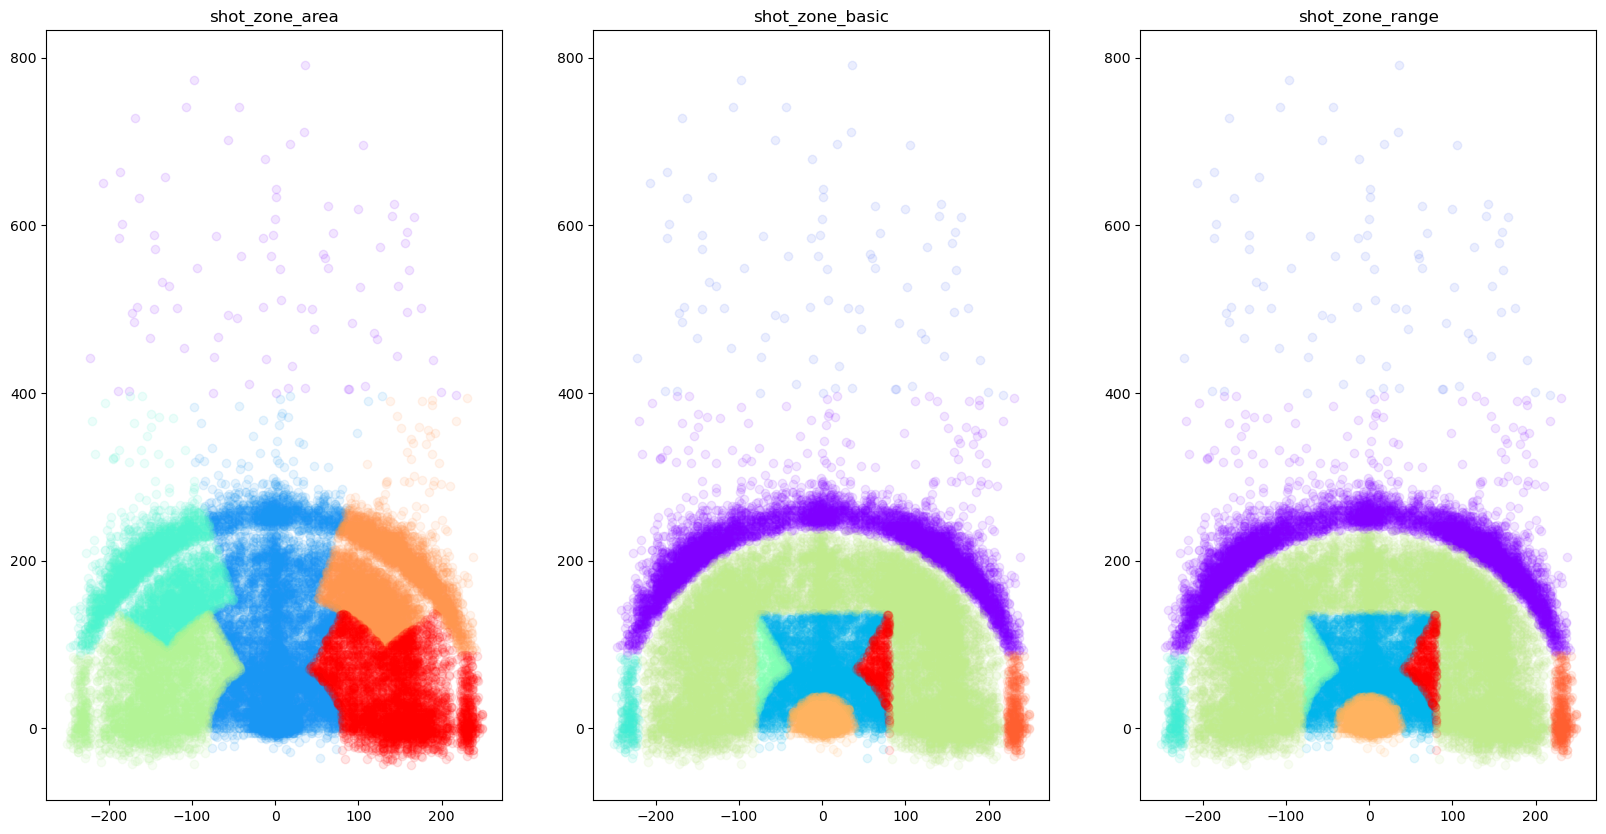

In [29]:
# Exploring the importance of shot zones
import matplotlib.cm as cm
plt.figure(figsize=(20,10))

def scatter_plot_by_category(feat):
    alpha = 0.1
    gs = kobe.groupby(feat)
    cs = cm.rainbow(np.linspace(0, 1, len(gs)))
    for g, c in zip(gs, cs):
        plt.scatter(g[1].loc_x, g[1].loc_y, color=c, alpha=alpha)

# shot_zone_area
plt.subplot(131)
scatter_plot_by_category('shot_zone_area')
plt.title('shot_zone_area')

# shot_zone_basic
plt.subplot(132)
scatter_plot_by_category('shot_type_new')
plt.title('shot_zone_basic')

# shot_zone_range
plt.subplot(133)
scatter_plot_by_category('shot_type_new2')
plt.title('shot_zone_range')

### *Shots made as a function of opponent* ###

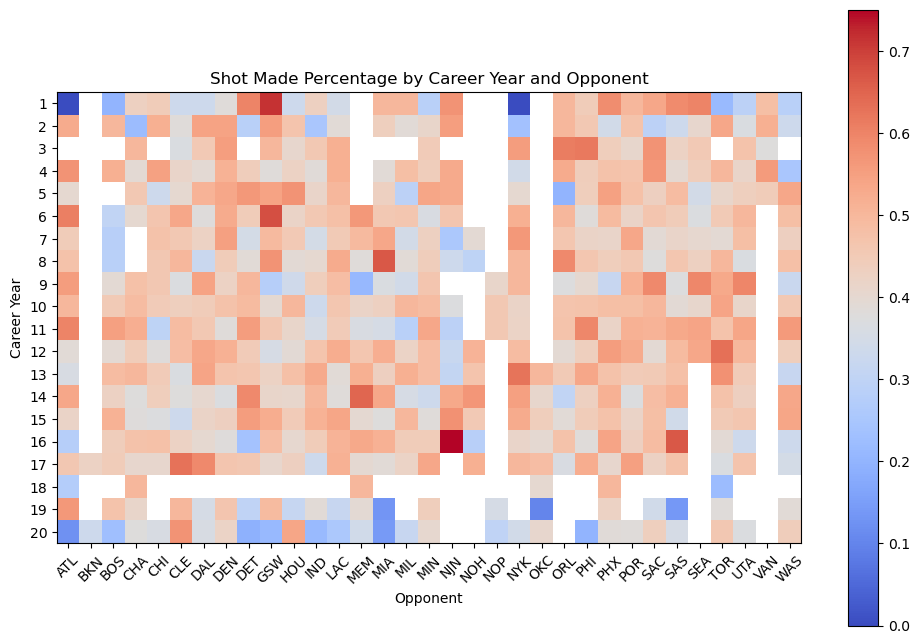

In [30]:
# Create a pivot table
table = pd.pivot_table(kobe, values='shot_made_flag', index='career_year', columns='opponent', aggfunc=np.mean)

# Create a heatmap
fig, ax = plt.subplots(figsize=(12,8))
im = ax.imshow(table, cmap='coolwarm')

# Set the tick labels for the x and y axes
ax.set_xticks(np.arange(len(table.columns)))
ax.set_xticklabels(table.columns, rotation=45)
ax.set_yticks(np.arange(len(table.index)))
ax.set_yticklabels(table.index)

# Add colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# Set title and axis labels
ax.set_title("Shot Made Percentage by Career Year and Opponent")
ax.set_xlabel("Opponent")
ax.set_ylabel("Career Year")

plt.show()


There's definitely something here, but given that we've got 20 years x 30+ teams, we'll need to do some dimensionality reduction. 

In [31]:
# Combine opponent x career_year
kobe['opponent_career_year'] = kobe['opponent'] + '_' + kobe['career_year'].astype(str)

# One hot encode the result:
onehot_opponentyear = pd.get_dummies(kobe['opponent_career_year'])

# Initialize a PCA model with the number of components you want to reduce to
num_components=20
pca = PCA(n_components=num_components)

# Fit the PCA model to your binary columns
pca.fit(onehot_opponentyear)

# Transform your binary columns into the lower-dimensional space using the fitted PCA model
pca_onehot = pd.DataFrame(pca.transform(onehot_opponentyear))

# Rename the columns of the transformed data to something more meaningful
new_col_names = ['Opponent_Year_PC{}'.format(i+1) for i in range(num_components)]
pca_onehot.columns = new_col_names

# Concatenate the transformed data with the original datafraem:
kobe = pd.concat([kobe, pca_onehot], axis=1)

### *Finalizing the features we'll include* ###

In [32]:
print(kobe.columns)
display(kobe)

Index(['action_type', 'combined_shot_type', 'game_event_id', 'game_id', 'lat',
       'loc_x', 'loc_y', 'lon', 'minutes_remaining', 'period', 'playoffs',
       'season', 'seconds_remaining', 'shot_distance', 'shot_made_flag',
       'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
       'team_id', 'team_name', 'game_date', 'matchup', 'opponent', 'shot_id',
       'time_in_period', 'time_elapsed', 'time_bin', 'home', 'playoffs_home',
       'career_year', 'month', 'year', 'months_into_season',
       'action_type_reduced', 'shot_distance_bin', 'shot_type_new',
       'shot_type_new2', 'opponent_career_year', 'Opponent_Year_PC1',
       'Opponent_Year_PC2', 'Opponent_Year_PC3', 'Opponent_Year_PC4',
       'Opponent_Year_PC5', 'Opponent_Year_PC6', 'Opponent_Year_PC7',
       'Opponent_Year_PC8', 'Opponent_Year_PC9', 'Opponent_Year_PC10',
       'Opponent_Year_PC11', 'Opponent_Year_PC12', 'Opponent_Year_PC13',
       'Opponent_Year_PC14', 'Opponent_Year_PC15', 'Oppone

,action_type,combined_shot_type,game_event_id,game_id,lat,loc_x,loc_y,lon,minutes_remaining,period,playoffs,season,seconds_remaining,shot_distance,shot_made_flag,shot_type,shot_zone_area,shot_zone_basic,shot_zone_range,team_id,team_name,game_date,matchup,opponent,shot_id,time_in_period,time_elapsed,time_bin,home,playoffs_home,career_year,month,year,months_into_season,action_type_reduced,shot_distance_bin,shot_type_new,shot_type_new2,opponent_career_year,Opponent_Year_PC1,Opponent_Year_PC2,Opponent_Year_PC3,Opponent_Year_PC4,Opponent_Year_PC5,Opponent_Year_PC6,Opponent_Year_PC7,Opponent_Year_PC8,Opponent_Year_PC9,Opponent_Year_PC10,Opponent_Year_PC11,Opponent_Year_PC12,Opponent_Year_PC13,Opponent_Year_PC14,Opponent_Year_PC15,Opponent_Year_PC16,Opponent_Year_PC17,Opponent_Year_PC18,Opponent_Year_PC19,Opponent_Year_PC20
0,Jump Shot,Jump Shot,10,20000012,33.9723,167,72,-118.1028,10,1,0,2000-01,27,18,NaN,2PT Field Goal,Right Side(R),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,1,10.450000,10,"(10.25, 10.5]",0,0,5,10,2000,0,Other,shot_distnace_8-22,Mid,Mid,POR_5,-0.009016,-0.008705,-0.006603,-0.006841,-0.010695,-0.009123,-0.004318,0.002095,-0.017482,-0.012476,-0.014837,-0.009352,-0.004859,-0.016366,-0.012791,0.003733,-0.018326,-0.033187,0.010314,-0.007798
1,Jump Shot,Jump Shot,12,20000012,34.0443,-157,0,-118.4268,10,1,0,2000-01,22,15,0.0,2PT Field Goal,Left Side(L),Mid-Range,8-16 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,2,10.366667,10,"(10.25, 10.5]",0,0,5,10,2000,0,Other,shot_distnace_8-22,Mid,Mid,POR_5,-0.009016,-0.008705,-0.006603,-0.006841,-0.010695,-0.009123,-0.004318,0.002095,-0.017482,-0.012476,-0.014837,-0.009352,-0.004859,-0.016366,-0.012791,0.003733,-0.018326,-0.033187,0.010314,-0.007798
2,Jump Shot,Jump Shot,35,20000012,33.9093,-101,135,-118.3708,7,1,0,2000-01,45,16,1.0,2PT Field Goal,Left Side Center(LC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,3,7.750000,7,"(7.5, 7.75]",0,0,5,10,2000,0,Other,shot_distnace_8-22,Mid,Mid,POR_5,-0.009016,-0.008705,-0.006603,-0.006841,-0.010695,-0.009123,-0.004318,0.002095,-0.017482,-0.012476,-0.014837,-0.009352,-0.004859,-0.016366,-0.012791,0.003733,-0.018326,-0.033187,0.010314,-0.007798
3,Jump Shot,Jump Shot,43,20000012,33.8693,138,175,-118.1318,6,1,0,2000-01,52,22,0.0,2PT Field Goal,Right Side Center(RC),Mid-Range,16-24 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,4,6.866667,6,"(6.75, 7.0]",0,0,5,10,2000,0,Other,shot_distnace_8-22,Mid,Mid,POR_5,-0.009016,-0.008705,-0.006603,-0.006841,-0.010695,-0.009123,-0.004318,0.002095,-0.017482,-0.012476,-0.014837,-0.009352,-0.004859,-0.016366,-0.012791,0.003733,-0.018326,-0.033187,0.010314,-0.007798
4,Driving Dunk Shot,Dunk,155,20000012,34.0443,0,0,-118.2698,6,2,0,2000-01,19,0,1.0,2PT Field Goal,Center(C),Restricted Area,Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-10-31,LAL @ POR,POR,5,6.316667,18,"(6.25, 6.5]",0,0,5,10,2000,0,Driving_Running_Cutting,shot_distnace_0-1,RA,RA,POR_5,-0.009016,-0.008705,-0.006603,-0.006841,-0.010695,-0.009123,-0.004318,0.002095,-0.017482,-0.012476,-0.014837,-0.009352,-0.004859,-0.016366,-0.012791,0.003733,-0.018326,-0.033187,0.010314,-0.007798
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,Jump Shot,Jump Shot,397,49900088,33.9963,1,48,-118.2688,6,4,1,1999-00,5,4,0.0,2PT Field Goal,Center(C),In The Paint (Non-RA),Less Than 8 ft.,1610612747,Los Angeles Lakers,2000-06-19,LAL vs. IND,IND,30693,6.083333,42,"(6.0, 6.25]",1,3,4,6,2000,7,Other,shot_distnace_4-7,C_ITP,C_ITP,IND_4,-0.009003,-0.008073,-0.008114,-0.008843,-0.008690,-0.009534,-0.011108,-0.004155,-0.009835,-0.006710,0.004735,0.007824,-0.017573,-0.005311,-0.009734,-0.008992,-0.015705,0.004402,-0.002050,-0.010103
30693,Tip Shot,Tip Shot,398,49900088,34.0443,0,0,-118.2698,6,

In [33]:
kobe['dist'] = np.sqrt(kobe['loc_x']**2 + kobe['loc_y']**2)

loc_x_zero = kobe['loc_x'] == 0
kobe.loc[~loc_x_zero, 'angle'] = np.arctan(kobe.loc[~loc_x_zero, 'loc_y'] / kobe.loc[~loc_x_zero, 'loc_x'])
kobe.loc[loc_x_zero, 'angle'] = np.pi / 2

In [53]:
kobe_final = kobe.drop(columns=[
        'action_type', 'combined_shot_type', 'game_event_id', 'game_id','lat',
        'lon', 'minutes_remaining', 'shot_distance_bin', 'shot_distance',
        'season', 'seconds_remaining','year', 'opponent',
        'shot_type', 'shot_zone_area', 'shot_zone_basic', 'shot_zone_range',
        'team_id', 'team_name', 'game_date', 'matchup', 'shot_id',
        'playoffs_home', 'month', 'opponent_career_year',
        'shot_type_new', 'time_bin'])

### *Transform the remaining columns* ###

In [54]:
# Select columns to be transformed
numeric_cols = kobe_final.select_dtypes(include=['int64', 'float64']).columns
binary_cols = [col for col in numeric_cols if set(kobe_final[col].unique()) == {0, 1}]
numeric_cols = [col for col in numeric_cols if col not in binary_cols]
string_cols = kobe_final.select_dtypes(include=['object', 'category']).columns

numeric_cols.remove('shot_made_flag')

# Standardize continuous numerical columns
scaler = StandardScaler()
kobe_final[numeric_cols] = scaler.fit_transform(kobe_final[numeric_cols])

# One-hot encode string columns
kobe_final = pd.get_dummies(kobe_final, columns=string_cols)

display(kobe_final)
print(kobe_final.shape)

,loc_x,loc_y,period,playoffs,shot_made_flag,time_in_period,time_elapsed,home,career_year,months_into_season,Opponent_Year_PC1,Opponent_Year_PC2,Opponent_Year_PC3,Opponent_Year_PC4,Opponent_Year_PC5,Opponent_Year_PC6,Opponent_Year_PC7,Opponent_Year_PC8,Opponent_Year_PC9,Opponent_Year_PC10,Opponent_Year_PC11,Opponent_Year_PC12,Opponent_Year_PC13,Opponent_Year_PC14,Opponent_Year_PC15,Opponent_Year_PC16,Opponent_Year_PC17,Opponent_Year_PC18,Opponent_Year_PC19,Opponent_Year_PC20,dist,angle,action_type_reduced_Alley Oop,action_type_reduced_Driving_Running_Cutting,action_type_reduced_Fadeaway,action_type_reduced_Finger Roll,action_type_reduced_Floating,action_type_reduced_Other,action_type_reduced_Pullup,action_type_reduced_Reverse,action_type_reduced_Step Back,action_type_reduced_Turnaround,shot_type_new2_ATB3,shot_type_new2_BC,shot_type_new2_C_ITP,shot_type_new2_L_3,shot_type_new2_L_ITP,shot_type_new2_Mid,shot_type_new2_RA,shot_type_new2_R_3,shot_type_new2_R_ITP
0,1.451920,-0.217651,-1.317069,0,NaN,1.467526,-0.926156,0,-1.112267,-1.329377,-0.093964,-0.093898,-0.073013,-0.076846,-0.121009,-0.104531,-0.050752,0.024831,-0.208168,-0.151438,-0.181737,-0.114805,-0.059792,-0.202289,-0.158979,0.046767,-0.230575,-0.421858,0.133751,-0.101647,0.457059,0.082269,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
1,-1.490250,-1.037790,-1.317069,0,0.0,1.443507,-0.926156,0,-1.112267,-1.329377,-0.093964,-0.093898,-0.073013,-0.076846,-0.121009,-0.104531,-0.050752,0.024831,-0.208168,-0.151438,-0.181737,-0.114805,-0.059792,-0.202289,-0.158979,0.046767,-0.230575,-0.421858,0.133751,-0.101647,0.195151,-0.323497,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
2,-0.981727,0.499972,-1.317069,0,1.0,0.689322,-1.137157,0,-1.112267,-1.329377,-0.093964,-0.093898,-0.073013,-0.076846,-0.121009,-0.104531,-0.050752,0.024831,-0.208168,-0.151438,-0.181737,-0.114805,-0.059792,-0.202289,-0.158979,0.046767,-0.230575,-0.421858,0.133751,-0.101647,0.317363,-1.249031,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
3,1.188578,0.955605,-1.317069,0,0.0,0.434725,-1.207490,0,-1.112267,-1.329377,-0.093964,-0.093898,-0.073013,-0.076846,-0.121009,-0.104531,-0.050752,0.024831,-0.208168,-0.151438,-0.181737,-0.114805,-0.059792,-0.202289,-0.158979,0.046767,-0.230575,-0.421858,0.133751,-0.101647,0.889069,0.576699,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0
4,-0.064569,-1.037790,-0.450252,0,1.0,0.276202,-0.363486,0,-1.112267,-1.329377,-0.093964,-0.093898,-0.073013,-0.076846,-0.121009,-0.104531,-0.050752,0.024831,-0.208168,-0.151438,-0.181737,-0.114805,-0.059792,-0.202289,-0.158979,0.046767,-0.230575,-0.421858,0.133751,-0.101647,-1.458904,1.242313,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30692,-0.055488,-0.491031,1.283381,1,0.0,0.208950,1.324521,1,-1.317869,2.167014,-0.093826,-0.087080,-0.089722,-0.099341,-0.098316,-0.109245,-0.130553,-0.049235,-0.117110,-0.081441,0.057998,0.096047,-0.216238,-0.065648,-0.120979,-0.112637,-0.197598,0.055954,-0.026581,-0.131698,-0.953096,1.221549,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0
30693,-0.064569,-1.037790,1.283381,1,NaN,0.208950,1.324521,1,-1.317869,2.167014,-0.093826,-0.087080,-0.089722,-0.099341,-0.098316,-0.109245,-0.130553,-0.049235,-0.117110,-0.081441,0.057998,0.096047,-0.216238,-0.065648,-0.120979,-0.112637,-0.197598,0.055954,-0.026581,-0.131698,-1.458904,1.242313,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0
30694,-1.281392,0.853087,1.283381,1,1.0,-0.545235,1.113520,1,-1.317869,2.167014,-0.093826,-0.087080,-0.089722,-0.099341,-0.098316,-0.109245,-0.130553,-0.049235,-0.117110,-0.081441,0.057998,0.096047,-0.216238,-0.065648,-0.120979,-0.112637,-0.197598,0.055954,-0.026581,-0.131698,0.788666,-1.212330,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0
30695,0.216935,2.003561,1.283381,1,0.0,-0.919925,1.043187,1,-1.317869,2.167014,-0.093826,-0.087080,-0.089722,-0.099341,-0.098316,-0.109245,-0.130553,-0.049235,

(30697, 51)


----------------------
# Creating and Running Our Model #
----------------------

### ATTEMPT 1 ###

Normally I would delete a model that performed poorly (which this did). However, because the training/ test sets are relatively small (and thus require little computational burden), I thought I might leave it in just in case it might be helpful for others (or myself) to see the initial thought process and to better understand what does and does not work for this type of classification task. 

In [55]:
kobe_temp = kobe_final[pd.notnull(kobe_final['shot_made_flag'])]
submission = kobe_final[pd.isnull(kobe_final['shot_made_flag'])]
submission = submission.drop(columns='shot_made_flag')

train = kobe_temp.drop(columns='shot_made_flag')
train_y = kobe_temp['shot_made_flag']

In [56]:
#logloss 
import scipy as sp
def logloss(act, pred):
    epsilon = 1e-15
    pred = np.maximum(epsilon, pred)
    pred = np.minimum(1-epsilon, pred)
    ll = sum(act*np.lib.scimath.log(pred) + np.subtract(1,act)*np.lib.scimath.log(np.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

In [57]:
# Finding the best number of trees (n_estimators) for RandomForestClassifier
print('Finding best n_estimators for RandomForestClassifier...')

# Initialize variables
min_score = 100000
best_n = 0
scores_n = []

# Define the range of number of trees to explore
range_n = np.logspace(0, 2, num=3).astype(int)

# Loop through each value of n_estimators
for n in range_n:
    print("the number of trees : {0}".format(n))
    t1 = time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(n_estimators=n)
    kf = KFold(n_splits=10, shuffle=True)
    
    # Perform cross-validation
    for train_k, test_k in kf.split(train):
        rfc.fit(train.iloc[train_k], train_y.iloc[train_k])
        pred = rfc.predict(train.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    
    scores_n.append(rfc_score)
    
    # Update the best score and corresponding number of trees if a better score is found
    if rfc_score < min_score:
        min_score = rfc_score
        best_n = n
        
    t2 = time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(n, t2-t1))

# Print the best number of trees and the corresponding score
print(best_n, min_score)

# Finding the best max_depth for RandomForestClassifier
print('Finding best max_depth for RandomForestClassifier...')

# Initialize variables
min_score = 100000
best_m = 0
scores_m = []

# Define the range of max_depth to explore
range_m = np.logspace(0, 2, num=3).astype(int)

# Loop through each value of max_depth
for m in range_m:
    print("the max depth : {0}".format(m))
    t1 = time()
    
    rfc_score = 0.
    rfc = RandomForestClassifier(max_depth=m, n_estimators=best_n)
    kf = KFold(n_splits=10, shuffle=True)
    
    # Perform cross-validation
    for train_k, test_k in kf.split(train):
        rfc.fit(train.iloc[train_k], train_y.iloc[train_k])
        pred = rfc.predict(train.iloc[test_k])
        rfc_score += logloss(train_y.iloc[test_k], pred) / 10
    
    scores_m.append(rfc_score)
    
    # Update the best score and corresponding max_depth if a better score is found
    if rfc_score < min_score:
        min_score = rfc_score
        best_m = m
    
    t2 = time()
    print('Done processing {0} trees ({1:.3f}sec)'.format(m, t2-t1))

# Print the best max_depth and the corresponding score
print(best_m, min_score)

Finding best n_estimators for RandomForestClassifier...
the number of trees : 1
Done processing 1 trees (0.952sec)
the number of trees : 10
Done processing 10 trees (8.413sec)
the number of trees : 100
Done processing 100 trees (82.947sec)
100 12.65729202292848
Finding best max_depth for RandomForestClassifier...
the max depth : 1
Done processing 1 trees (7.525sec)
the max depth : 10
Done processing 10 trees (44.692sec)
the max depth : 100
Done processing 100 trees (82.606sec)
10 11.649176954545398


Text(0.5, 0, 'max depth')

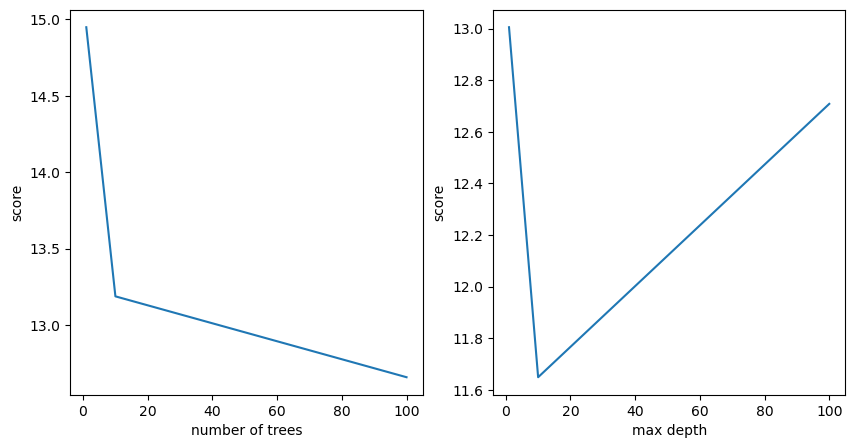

In [58]:
# Create a figure with two subplots
plt.figure(figsize=(10, 5))
plt.subplot(121)

# Plotting the scores for different numbers of trees
plt.plot(range_n, scores_n)
plt.ylabel('score')
plt.xlabel('number of trees')

plt.subplot(122)

# Plotting the scores for different max depths
plt.plot(range_m, scores_m)
plt.ylabel('score')
plt.xlabel('max depth')

In [59]:
# Create a RandomForestClassifier with the best number of trees
forest = RandomForestClassifier(n_estimators=best_n, random_state=0)

# Fit the RandomForestClassifier on the training data
forest.fit(train, train_y)

# Calculate feature importances
importances = forest.feature_importances_

# Calculate the standard deviation of feature importances across all trees
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)

# Create a pandas Series to display feature importances sorted in descending order
feature_scores = pd.Series(forest.feature_importances_, index=train.columns).sort_values(ascending=False)

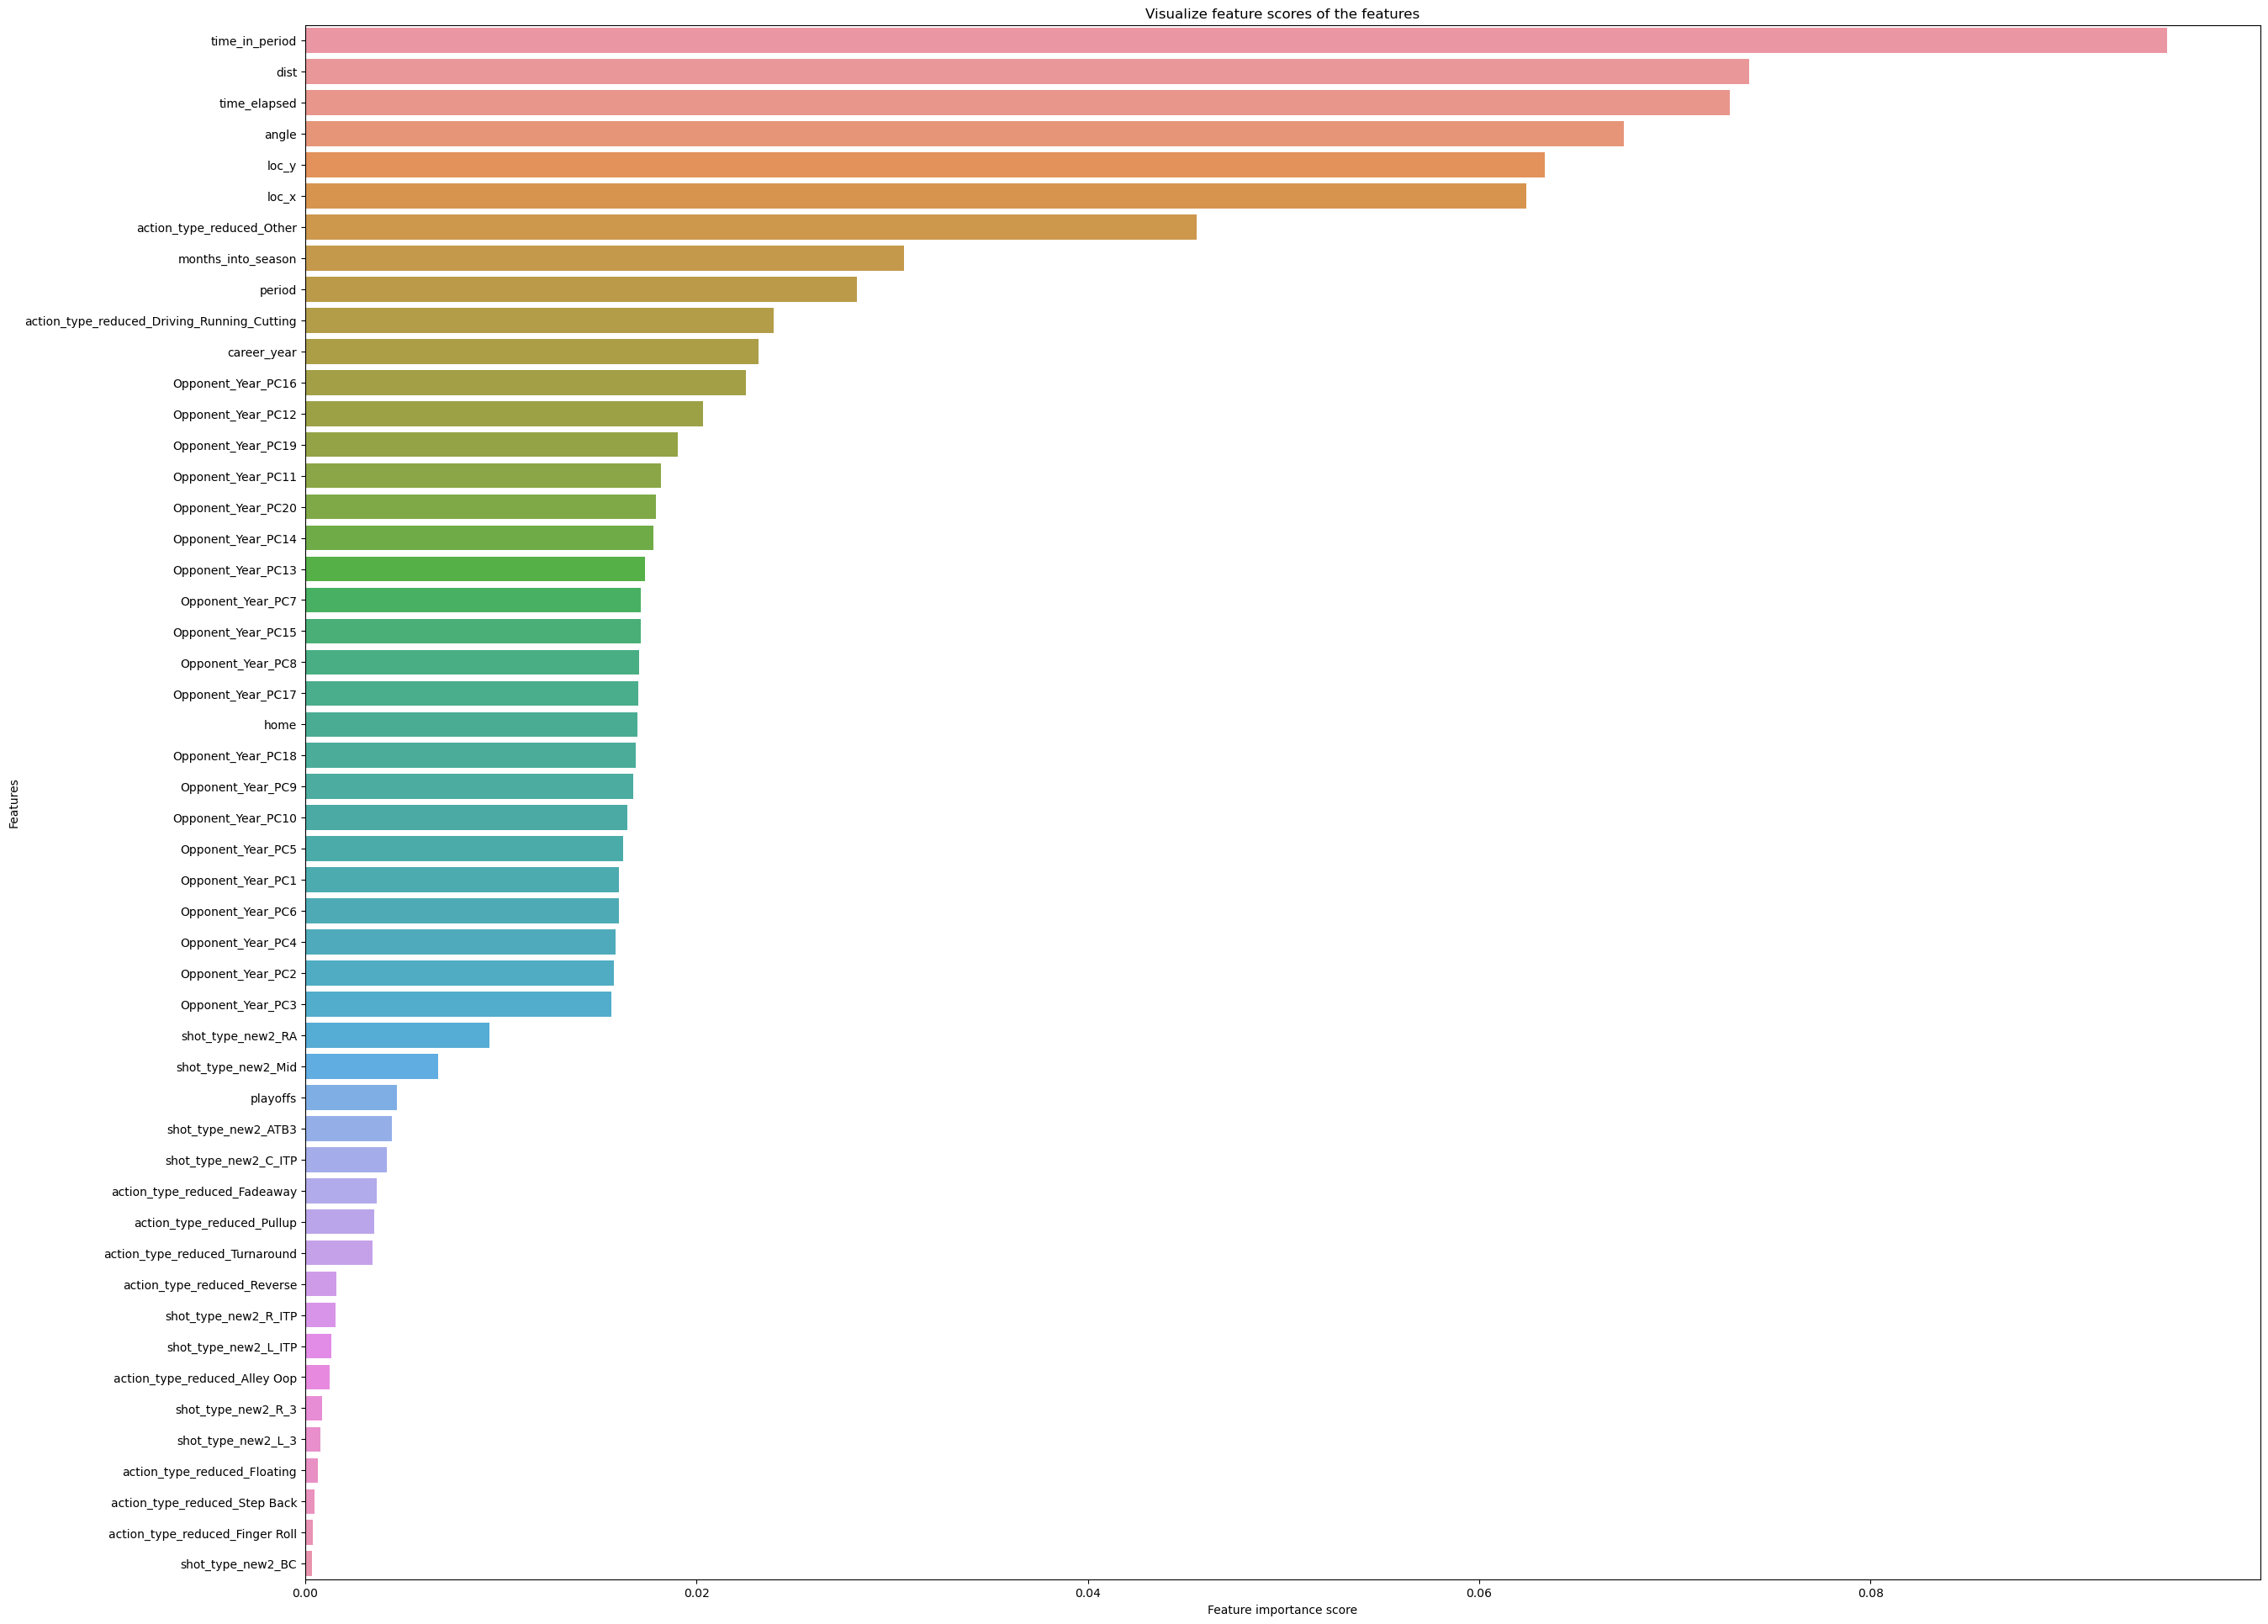

In [60]:
# Create a figure and axis object with a specified size
f, ax = plt.subplots(figsize=(30, 24))

# Create a bar plot using seaborn's barplot function
ax = sns.barplot(x=feature_scores, y=feature_scores.index)

# Set the title of the plot
ax.set_title("Visualize feature scores of the features")

# Set the y-tick labels to be the feature names
ax.set_yticklabels(feature_scores.index)

# Set the x-label of the plot
ax.set_xlabel("Feature importance score")

# Set the y-label of the plot
ax.set_ylabel("Features")

# Display the plot
plt.show()

#### **Conclusion:** ####

* The expected features of time in period, shot distance, and shot position played an important role in classifying shots as successful or not.

In [61]:
# Create a RandomForestClassifier with the best number of trees and max depth
model = RandomForestClassifier(n_estimators=best_n, max_depth=best_m)

# Fit the RandomForestClassifier on the training data
model.fit(train, train_y)

# Make predictions on the 'submission' data using the trained model
# The 'predict_proba()' method returns the predicted probabilities for each class
pred = model.predict_proba(submission)


In [62]:
# Prepare Submission
sub = pd.read_csv("../input/kobe-bryant-shot-selection/sample_submission.csv.zip")
sub['shot_made_flag'] = pred
sub.to_csv("kobe_submission3.csv", index=False)

### ATTEMPT 2 ###

Here is the actual model that I used to perform this classification task. It is quite simple, and I believe that it could be further optimized (which I may work on in the future when I have more time). That said, my goal in this script was to focus on EDA, and to better understand the impact that effective feature engineering can have on model performance-- Something I think this demonstrates pretty well! 

In [63]:
# Select rows where 'shot_made_flag' is NaN
nanRows = kobe_final.loc[kobe_final['shot_made_flag'].isnull()]

# Reset the index of the nanRows DataFrame
nanRows.index = range(len(nanRows))

# Select rows where 'shot_made_flag' is not NaN
fullRows = kobe_final.loc[~kobe_final['shot_made_flag'].isnull()]

# Create the test set (X_test) by dropping the 'shot_made_flag' column from nanRows
X_test = nanRows.drop('shot_made_flag', axis=1)

# Create the feature matrix (X) by dropping the 'shot_made_flag' column from fullRows
X = fullRows.drop('shot_made_flag', axis=1)

# Create the target vector (Y) by copying the 'shot_made_flag' column from fullRows
Y = fullRows['shot_made_flag'].copy()

In [64]:
# Set the seed value for reproducibility
seed = 50

# Set the number of processors to use
processors = 1

# Set the number of folds for cross-validation
num_folds = 5

# Calculate the number of instances in the feature matrix
num_instances = len(X)

# Set the scoring metric for evaluation
scoring = 'neg_log_loss'

# Set the number of trees for the Random Forest model
num_trees = 100

# Calculate the number of features in the feature matrix
num_features = len(X.columns)

# Create a KFold object for cross-validation
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)

# Create a list to store the models
models = []

# Append different models to the list
models.append(('Logistic regression', LogisticRegression(max_iter=10000)))
models.append(('Random Forest', RandomForestClassifier()))
models.append(('Ada Boost', AdaBoostClassifier()))
models.append(('Gradient Boosting', GradientBoostingClassifier()))
models.append(('XGBoost', xgb.XGBClassifier()))

In [65]:
# Create empty lists to store the evaluation results
results = []
names = []
stds = []
means = []

# Iterate over each model in the 'models' list
for name, model in models:
    # Perform cross-validation and obtain the results
    cv_results = cross_val_score(model, X, Y, cv=kfold, scoring='neg_log_loss', n_jobs=1)
    
    # Print the cross-validation results
    print(cv_results)
    
    # Print the mean and standard deviation of the cross-validation results
    print("{0}: ({1:.3f}) +/- ({2:.3f})".format(name, cv_results.mean(), cv_results.std()))
    
    # Append the cross-validation results, model name, standard deviation, and mean to the respective lists
    results.append(cv_results)
    names.append(name)
    stds.append(cv_results.std())
    means.append(abs(cv_results.mean()))

[-0.63402212 -0.63347309 -0.6315453  -0.63485598 -0.62519777]
Logistic regression: (-0.632) +/- (0.003)
[-0.66585532 -0.66607512 -0.66618389 -0.68510274 -0.67340335]
Random Forest: (-0.671) +/- (0.007)
[-0.69002783 -0.68955568 -0.68951358 -0.68977702 -0.68933128]
Ada Boost: (-0.690) +/- (0.000)
[-0.62438303 -0.62543894 -0.6235148  -0.62623478 -0.61868391]
Gradient Boosting: (-0.624) +/- (0.003)
[-0.65984022 -0.65969401 -0.656843   -0.65811249 -0.64952793]
XGBoost: (-0.657) +/- (0.004)


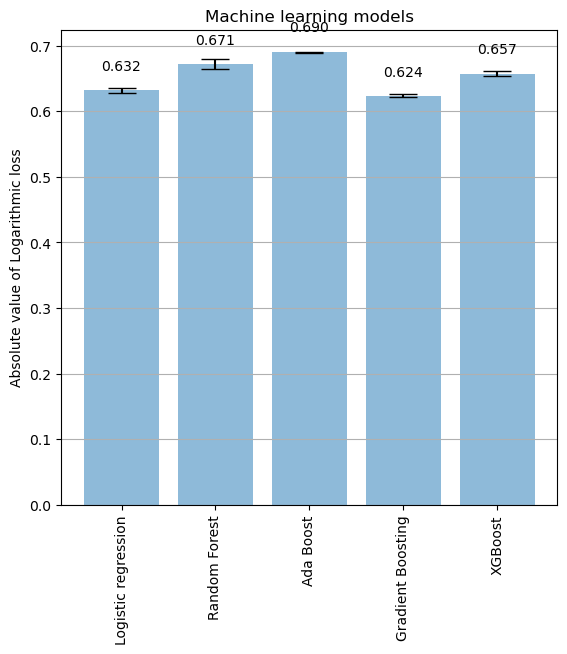

In [66]:
# Create an array of x positions for the bars, one for each model
x_pos = np.arange(len(models))

# Create a new figure and axis
fig, ax = plt.subplots()

# Build the bar plot with error bars
rects1 = ax.bar(x_pos, means, yerr=stds, align='center', alpha=0.5, ecolor='black', capsize=10)

# Set the y-axis label
ax.set_ylabel('Absolute value of Logarithmic loss')

# Set the x-axis tick positions and labels
ax.set_xticks(x_pos)
ax.set_xticklabels(names)

# Set the title of the plot
ax.set_title('Machine learning models')

# Add gridlines to the y-axis
ax.yaxis.grid(True)

# Adjust the layout of the plot to make space for the title
plt.subplots_adjust(top=1.1)

# Function to label each bar with its height
def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., 1.04*height,
                '%.3f' % height,
                ha='center', va='bottom')

# Call the autolabel function to add labels to the bars
autolabel(rects1)

# Rotate the x-axis tick labels vertically for better readability
plt.xticks(rotation='vertical')

# Display the plot
plt.show()


In [71]:
# Create an instance of the XGBoost classifier with specified hyperparameters
model = xgb.XGBClassifier(seed=1, learning_rate=0.01, n_estimators=500, max_depth=7, subsample=0.8, colsample_bytree=0.6)

# Fit the model to the training data
model.fit(X, Y)

# Use the trained model to predict the probabilities of positive class (shot made) for the test data
nanRows.loc[:, 'shot_made_flag'] = model.predict_proba(X_test)[:, 1].copy()

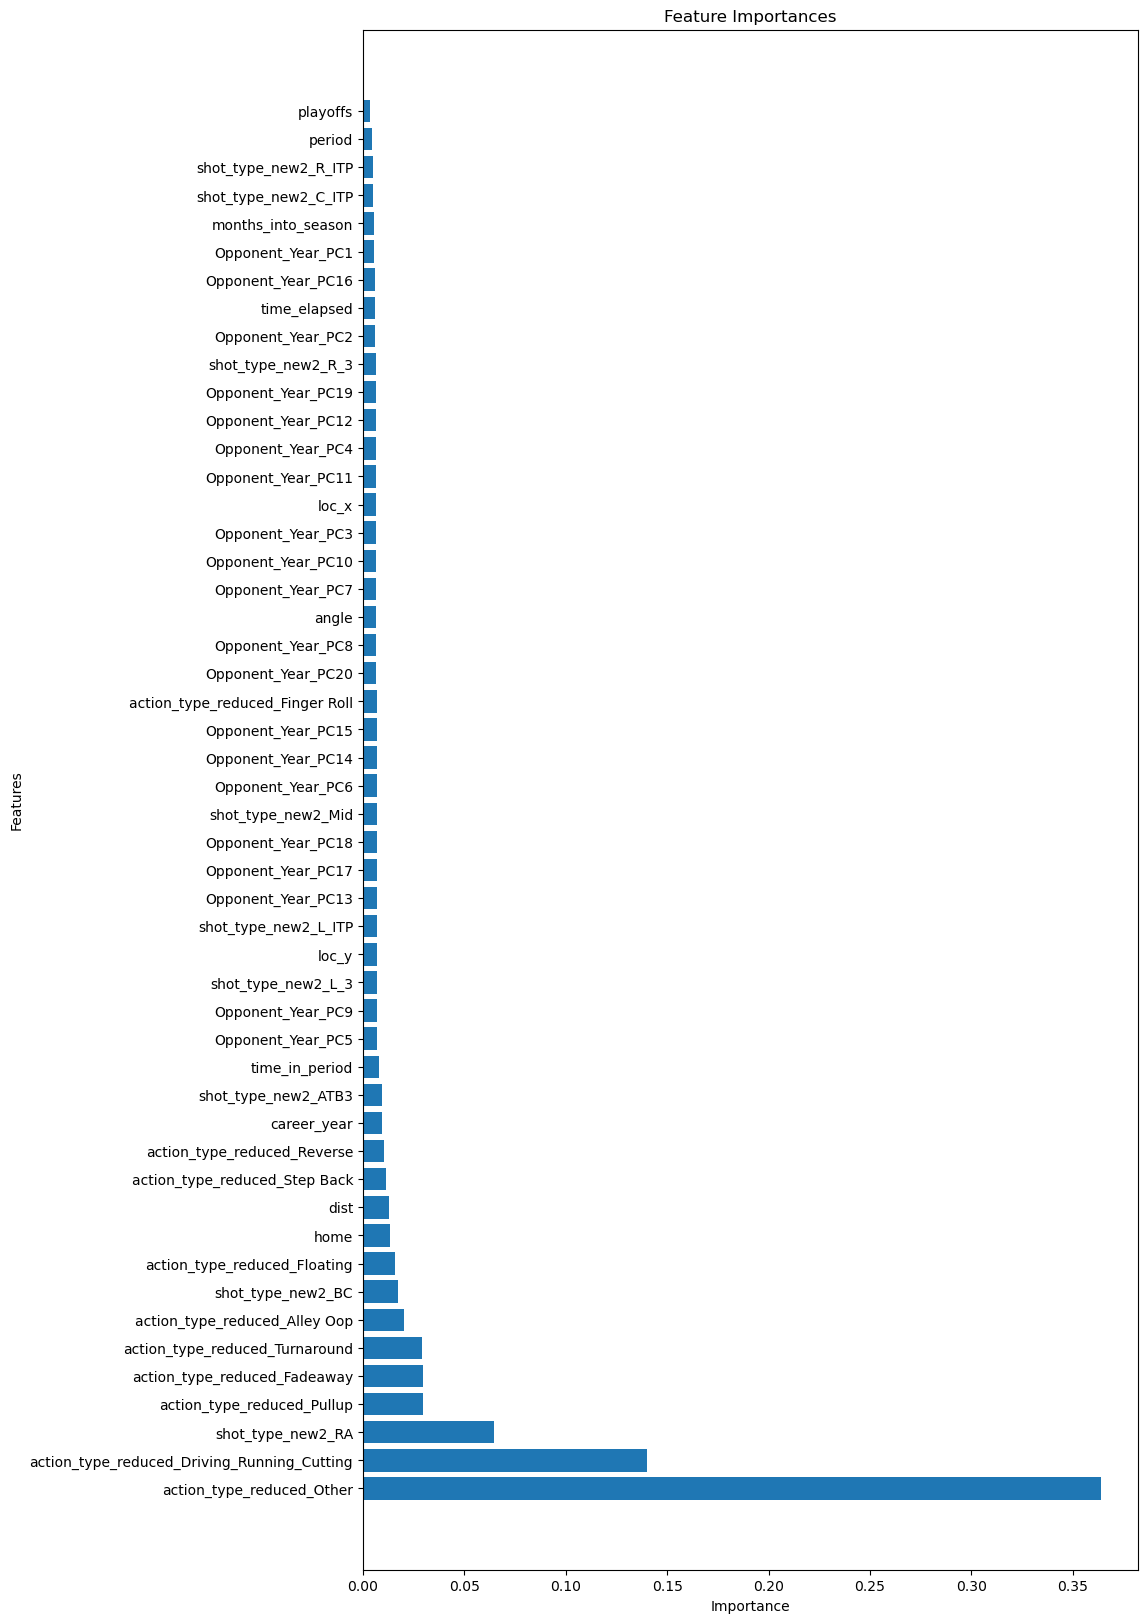

In [72]:
# Get feature importances
importances = model.feature_importances_

# Get feature names
feature_names = X.columns

# Create a list of (feature, importance) pairs
feature_importance_pairs = list(zip(feature_names, importances))

# Sort the feature importance pairs by importance (descending order)
feature_importance_pairs.sort(key=lambda x: x[1], reverse=True)

# Separate the feature names and importances
sorted_features, sorted_importances = zip(*feature_importance_pairs)

# Plotting the feature importances
plt.figure(figsize=(10, 20))
plt.barh(range(len(sorted_importances)), sorted_importances, tick_label=sorted_features)
plt.xlabel('Importance')
plt.ylabel('Features')
plt.title('Feature Importances')
plt.show()

----------------------
# Create Submission #
----------------------

In [73]:
submission = pd.DataFrame()
submission['shot_id'] = shot_id_rows['shot_id']
submission['shot_made_flag'] = nanRows['shot_made_flag']
submission
submission.to_csv('submission_final2.csv', index=False)